In [11]:
# SETUP
# load all packages and read in most all data for this notebook
library(raster)
library(data.table)
library(ggplot2)
library(lubridate)

wdata <- fread('wdata.csv') # historical, site-specific weather data downloaded from gridMet
generatedAnomData <- readRDS('ExampleData/generatedAnomData') # generated anomalies at the lead-level
MonthlyAnoms <- fread('ExampleData/MonthlyAnoms.csv') # anomalies averaged to the monthly level

HistDataNormMean <- fread('ExampleData/HistDataNormMean.csv') # Summarized temperature and soil moisture values for the historical normal period (1981 - 2010)
AnomRunStats <- fread('ExampleData/AnomRunStats.csv') #Summarize temperature and soil moisture values for the future period

source('functions/weatherFunctions.R') 
currMonth <- month(Sys.Date())
Nleads <- 12


# Introduction

The intention of the short-term drought forecaster (STDF) is to predict weather and soil moisture for the upcoming year at a fine temporal and spatial scale.

The Climate Prediction Center (CPC) of the National Weather Service (NWS) provides “long-lead” outlooks for temperature and precipitation for 102 regions in the lower 48 of the United States.

![image](images/Screen Shot 2020-05-03 at 6.40.01 PM.png)

These outlooks consist of the probability of whether a region will be hotter or cooler (temperature) and wetter or drier (precipitation) than their 30-year climatological normal (1980-2010) for 1 1-month and 13 3-month outlooks. These outlooks are updated on the 15th of each month and the 1-month outlook is for the nearest upcoming month while the 3-month outlooks consist of 13 total forecasts for the next year. The 3-month outlooks overlap one another, and each individual month is included in up to 3 outlooks. For example, on May 15th, the closest 1-month outlook would be for June, and the nearest 3-month outlook would be for June-July-August. There are subsequent outlooks for July-August-September, August-September-October, and so on for the next 13 month period.

![image](https://www.cpc.ncep.noaa.gov/products/predictions/multi_season/13_seasonal_outlooks/color/page2.gif)

# National Weather Service Forecasts

The NWS uses "probability of exceedance" curves to give the forecast probability that a temperature or precipitation quantity will be exceeded at the location in question, for the forecast period. 

[temperature probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=t)

[precipitation probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=p)

In addition to the probability of exceedance, a ‘point forecast’ is given for the mean forecasted anomaly and the standard deviation (SD) of that anomaly, as well as percentile (%ile) that this mean will exceed the climatological mean (top left corners of the above figures). These probability of exceedance curves are generated for each outlook and region and are the basis for the information we see in the maps above. NWS meteorologists makes these forecasts using a series of models and tools that evaluate historical patterns as well as current global atmospheric and oceanic patterns. Full discussion [here](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/tools.php).

Our intent with the short-term forecaster is to translate the information from the NWS CPC into predictions that are fine-tuned for specific locations, instead of the broad outlooks provided for 102 regions. In addition, we translate these predictions to a finer temporal scale, so we are able to utilize them as the climate driver in in a daily driven, water-balance model, SOILWAT2. SOILWAT2 is a site-specific model, that takes inputs about daily weather, vegetation, and soils (multi-layer), and mechanistically predicts daily soil moisture, a metric used for evaluating likely success of plant germination and survival.

# Downscaling Methods

First, for each set of coordinates, the appropriate region is determined from the map above and the affiliated temperature and precipitation NWS long-lead forecast data are grabbed. Temperature and precipitation data are stored online in tabular form, [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllftd.dat) and [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllfpd.dat).


In [12]:
# Set coordinates
lat <- 35.1266
lng <- -111.5854

# Determine Region from coordinates and shapefile ------------------------------------------
CD102 <- shapefile(x = 'CD102/CD102.shp')
points <- data.frame(x = lng, y = lat)

coordinates(points) <- ~ x + y 
proj4string(points) <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")

CDRegion <- as.numeric(over(points, CD102)$ID4)

# Read in and subset anomaly data -----------------------------------------------------------
TempAnomsWhole <- fread('CurrentAnomalyTempData.csv') # this data is downloaded from the NWS website
TempAnoms <- subset(TempAnomsWhole, CD == CDRegion)
TempAnoms <- TempAnoms[1:Nleads, ]

PPTAnomsWhole <- fread('CurrentAnomalyPPTData.csv') # this data is downloaded from the NWS website
PPTAnoms <- subset(PPTAnomsWhole, CD == CDRegion)
PPTAnoms <- PPTAnoms[1:Nleads, ]

# Convert values and calculate NWS anomalies or correction factors \-------------------------------------------
  
# Temp
TempAnoms$ClimatologicalMEAN_Temp_C <- (TempAnoms$ClimatologicalMEAN - 32) * (5/9)
TempAnoms$ForecastedMEAN_Temp_C <- (TempAnoms$ForecastedMEAN - 32) * (5/9)
  
TempAnoms$ForecastedSD_Temp_C <- (TempAnoms$ForecastedSD) * (5/9)
TempAnoms$Anom_F <- TempAnoms$ForecastedMEAN - TempAnoms$ClimatologicalMEAN
TempAnoms$Anom_C <- TempAnoms$Anom_F * (5/9)
  
# PPT - keep in transformed units for calcs downstream
## PPT - SDs are given in transformed units. Means are in inches. 
backT <- 1/PPTAnoms$PO

# convert
PPTAnoms$ClimatatologicalMEAN_PPT_PO <- PPTAnoms$ClimatologicalMEAN ^ PPTAnoms$PO
PPTAnoms$ClimatatologicalMEAN_PPT_cm <- PPTAnoms$ClimatologicalMEAN * 2.54
  
PPTAnoms$ForecastedMEAN_PPT_PO <- PPTAnoms$ForecastedMEAN ^ PPTAnoms$PO
PPTAnoms$ForecastedMEAN_PPT_cm <- PPTAnoms$ForecastedMEAN * 2.54
  
PPTAnoms$ForecastedSD_PPT_in <- as.numeric(PPTAnoms$ForecastedSD) ^ backT
PPTAnoms$ForecastedSD_PPT_cm <- PPTAnoms$ForecastedSD_PPT_in * 2.54
  
# calc - anomaly NEEDS to be calcualted in transformed units
PPTAnoms$Anom_PO <- PPTAnoms$ForecastedMEAN_PPT_PO - PPTAnoms$ClimatatologicalMEAN_PPT_PO
PPTAnoms$Anom_cm <- PPTAnoms$ForecastedMEAN_PPT_cm - PPTAnoms$ClimatatologicalMEAN_PPT_cm
PPTAnoms$Anom_CF <- PPTAnoms$ForecastedMEAN / PPTAnoms$ClimatologicalMEAN
  
print('NWS Temperature Data')
TempAnoms
print('NWS Precipitation Data')
PPTAnoms

[1] "NWS Temperature Data"


YEAR MN LEAD CD ForecastedMEAN ClimatologicalMEAN ForecastedSD
1  2020 5   1   97 70.97          69.98              1.2039      
2  2020 5   2   97 69.64          68.80              1.0297      
3  2020 5   3   97 63.00          62.12              1.0835      
4  2020 5   4   97 53.41          52.51              1.2727      
5  2020 5   5   97 43.42          42.38              1.3283      
6  2020 5   6   97 36.88          35.83              1.6065      
7  2020 5   7   97 35.00          34.40              1.8439      
8  2020 5   8   97 38.35          37.68              1.6754      
9  2020 5   9   97 44.15          43.17              1.5151      
10 2020 5  10   97 50.73          50.22              1.8356      
11 2020 5  11   97 58.91          58.37              1.8835      
12 2020 5  12   97 66.95          65.99              1.5450      
   ClimatologicalSD ClimatologicalMEAN_Temp_C ForecastedMEAN_Temp_C
1  1.35             21.100000                 21.650000            
2  1.14             20.444444                 20.911111            
3  1.19             16.733333                 17.222222            
4  1.40             11.394444                 11.894444            
5  1.44              5.766667                  6.344444            
6  1.64              2.127778                  2.711111            
7  1.92              1.333333                  1.666667            
8  1.76              3.155556                  3.527778            
9  1.56              6.205556                  6.750000            
10 1.91             10.122222                 10.405556            
11 2.07             14.650000                 14.950000            
12 1.68             18.883333                 19.416667            
   ForecastedSD_Temp_C Anom_F Anom_C   
1  0.6688333           0.99   0.5500000
2  0.5720556           0.84   0.4666667
3  0.6019444           0.88   0.4888889
4  0.7070556           0.90   0.5000000
5  0.7379444           1.04   0.5777778
6  0.8925000           1.05   0.5833333
7  1.0243889           0.60   0.3333333
8  0.9307778           0.67   0.3722222
9  0.8417222           0.98   0.5444444
10 1.0197778           0.51   0.2833333
11 1.0463889           0.54   0.3000000
12 0.8583333           0.96   0.5333333

[1] "NWS Precipitation Data"


YEAR MN LEAD CD ForecastedMEAN ClimatologicalMEAN ForecastedSD
1  2020 5   1   97 4.72           4.72               0.3000      
2  2020 5   2   97 5.89           5.89               0.4800      
3  2020 5   3   97 5.22           5.20               0.5051      
4  2020 5   4   97 3.72           3.66               0.2998      
5  2020 5   5   97 3.74           3.33               0.2481      
6  2020 5   6   97 3.30           3.30               0.2400      
7  2020 5   7   97 3.86           3.42               0.2306      
8  2020 5   8   97 3.86           3.68               0.2296      
9  2020 5   9   97 3.28           3.27               0.4000      
10 2020 5  10   97 2.54           2.49               0.3578      
11 2020 5  11   97 1.43           1.43               0.2000      
12 2020 5  12   97 2.76           2.76               0.3600      
   ClimatologicalSD PO   2.    ⋯ 98.  ClimatatologicalMEAN_PPT_PO
1  0.30             0.49  7.93 ⋯ 2.37 2.139102                   
2  0.48             0.61  9.46 ⋯ 3.03 2.949649                   
3  0.51             0.68  7.95 ⋯ 2.81 3.068190                   
4  0.30             0.40  7.74 ⋯ 1.09 1.680322                   
5  0.25             0.28  9.97 ⋯ 0.64 1.400504                   
6  0.24             0.27 10.25 ⋯ 0.64 1.380380                   
7  0.24             0.25 10.99 ⋯ 0.58 1.359899                   
8  0.23             0.28  9.65 ⋯ 0.81 1.440248                   
9  0.40             0.51  6.57 ⋯ 0.94 1.829866                   
10 0.36             0.48  5.45 ⋯ 0.61 1.549443                   
11 0.20             0.29  4.26 ⋯ 0.29 1.109296                   
12 0.36             0.54  5.34 ⋯ 0.99 1.730178                   
   ClimatatologicalMEAN_PPT_cm ForecastedMEAN_PPT_PO ForecastedMEAN_PPT_cm
1  11.9888                     2.139102              11.9888              
2  14.9606                     2.949649              14.9606              
3  13.2080                     3.076210              13.2588              
4   9.2964                     1.691286               9.4488              
5   8.4582                     1.446785               9.4996              
6   8.3820                     1.380380               8.3820              
7   8.6868                     1.401673               9.8044              
8   9.3472                     1.459636               9.8044              
9   8.3058                     1.832718               8.3312              
10  6.3246                     1.564300               6.4516              
11  3.6322                     1.109296               3.6322              
12  7.0104                     1.730178               7.0104              
   ForecastedSD_PPT_in ForecastedSD_PPT_cm Anom_PO     Anom_cm Anom_CF 
1  0.085684155         0.217637755         0.000000000 0.0000  1.000000
2  0.300223478         0.762567633         0.000000000 0.0000  1.000000
3  0.366260638         0.930302021         0.008019568 0.0508  1.003846
4  0.049212913         0.125000799         0.010964782 0.1524  1.016393
5  0.006885773         0.017489865         0.046281068 1.0414  1.123123
6  0.005063911         0.012862334         0.000000000 0.0000  1.000000
7  0.002827725         0.007182422         0.041774783 1.1176  1.128655
8  0.005221036         0.013261433         0.019387234 0.4572  1.048913
9  0.165853818         0.421268697         0.002851785 0.0254  1.003058
10 0.117512491         0.298481728         0.014857206 0.1270  1.020080
11 0.003888290         0.009876256         0.000000000 0.0000  1.000000
12 0.150777995         0.382976108         0.000000000 0.0000  1.000000

Note: Long-lead forecasts are predictions for rolling 3-month long windows. Temperature values (C) are means across 3-month windows and precipitation values (inches) are sums. For example, a Lead of 1, refers to the months of June-July-August, Lead 2 refers to July-August-September, and so on and so forth. In order to correctly predict monthly values from the lead data we need to look at what leads are affiliated with each month. To switch between leads and months, we create a monthLeads table.

In [13]:
print("Months & Leads Table")

monthLeads <- makeMonthLeadRelationshipTable(TempAnoms)
monthLeads


[1] "Months & Leads Table"


LEAD Month lead1 lead2 lead3
1   1    7     1    NA    NA   
2   2    8     2     1    NA   
3   3    9     3     2     1   
4   4   10     4     3     2   
5   5   11     5     4     3   
6   6   12     6     5     4   
7   7    1     7     6     5   
8   8    2     8     7     6   
9   9    3     9     8     7   
10 10    4    10     9     8   
11 11    5    11    10     9   
12 12    6    12    11    10

Next, because the future forecast for each lead are probability curves of potential values we want to create a numerical distribution of potential futures using the NWS data. To accomplish this, we use multivariate sampling that considers the covariance between historical temperature and precipitation anomalies, as well as the NWS forecast for the mean and standard deviation in the coming months. 

For these broad forecasts to reflect site-specific climatology we apply these regional anomalies to site-specific historical data. Specifically, for a point location (lat, long) historical weather data (1980 – current) is downloaded from [gridMet](http://www.climatologylab.org/gridmet.html), a daily, high-spatial resolution surface meteorological dataset, using the geoknife package.

To create our sample, we first calculate monthly mean temperature and the monthly sum of precipitation for each month in a 30 year climatic normal period (1981 - 2020). Then, using the roll apply function, we mean and sum these monthly values to their affiliated NWS lead. The difference between the NWS lead and historical lead data is calculated, to create an array of meteorological anomalies. The covariance between the lead anomaly values is then calculated in order to apply multivariate sampling. The multivariate sample considerrs each lead period and looks at covariance, the forecasted standard deviation, and the forecasted anomaly. All precipitation calculations are performed in transformed units.

We would expect these generated anomaly values to have the same mean, standard deviation, and covariance structure as our dataset. Below we are looking at a sample set of anomalies (n = 100)

[,1]       [,2]       [,3]       [,4]       [,5]         [,6]       
 [1,]  1.8449347  0.9308113  0.3216446  0.5880400 -0.211170008  1.17215152
 [2,] -0.3672249  1.1232460 -0.2099762  1.0310186  0.262663404  1.84139458
 [3,]  0.1284352  0.6294553 -0.2304067  1.3898376  0.472959536  1.10787002
 [4,]  0.4349684  0.3738204  0.1785234  0.8481657  0.490616301  1.60211718
 [5,]  1.0703445  0.8793952  1.6558532  0.8269575  1.141214028  0.57729334
 [6,]  1.8850551  1.4405231 -0.2454459  1.4599064 -0.393949162 -0.37662423
 [7,]  1.3984539  0.5800605  2.3815063  1.8012319  1.531242838 -1.49944267
 [8,] -0.2813409  0.6717500 -0.8260572 -1.4798507  1.505348187  0.85203311
 [9,]  0.6337638  0.3658186  0.6658819 -0.2465430 -0.419707093 -0.33775338
[10,]  0.2623375 -0.1977389  0.2933984  1.3444288 -0.003167321  1.45122806
[11,]  1.9120719 -0.3998638  0.2715049 -0.1300664  1.211311885  0.01666561
[12,]  1.5967501  0.5330922  0.1788633  0.9198971  1.850460703 -0.05013836
      [,7]        [,8]       [,9]       [,10]       [,11] [,12]      [,13]     
 [1,]  0.57282020  0.1678543  1.1852326  0.21549944 ⋯      1.4887226  1.3175794
 [2,]  0.80961786  0.8805546  0.1141114  0.24146765 ⋯      0.5635483  1.0803951
 [3,]  0.02395497  1.5150541 -0.3914981  1.09252091 ⋯      0.8005121  0.2950461
 [4,]  0.35280003 -0.1325319 -0.5760386 -1.05790860 ⋯      0.5431721 -0.1608758
 [5,]  0.89214421  0.6969724 -0.2751810  0.07280557 ⋯      0.1295515  0.2931493
 [6,] -0.71630674  0.7721452  0.9387386  0.51457722 ⋯      0.6166929  1.0647618
 [7,]  2.45824791 -1.6448860  0.4317151  0.73367297 ⋯     -0.5203638  1.3489666
 [8,]  0.18161680  1.8053408  0.5180443 -1.08463520 ⋯     -0.8451130  1.2300640
 [9,]  1.45776143  0.7176030 -1.0384833  1.31646823 ⋯      1.4460315 -0.2052498
[10,] -0.94526154 -0.9686996 -0.1837326  0.51830315 ⋯      0.1423498  0.4638023
[11,] -0.12251384  0.6924782  1.8103167  0.95534037 ⋯     -0.2930124 -0.3396316
[12,]  0.08972090  0.7415844  0.6626474  1.43903719 ⋯     -0.2064298 -1.6859860
      [,14]       [,15]       [,16]       [,17]         [,18]       [,19]      
 [1,]  0.14605927  0.76583031  1.12884472  0.8911036677 -1.74397406  0.85657118
 [2,]  0.30167562  0.28543870 -0.82303541  0.9568754262  0.23183581  0.74646053
 [3,]  0.74660532  0.92856864  0.81795582  1.6195000184  0.06313224 -0.39762587
 [4,] -0.30130431  0.20400531  1.36069025  0.0353457554  0.05458262  0.13114929
 [5,] -0.37063556  1.67556383  0.08479823  1.7546422248  0.25122123  0.06394877
 [6,] -0.10160461 -0.98034983  0.84954968  0.9539462595  1.38281294 -0.37456487
 [7,] -0.04625345 -0.04332275  0.82469540 -0.0005925624 -0.45944146  0.81301478
 [8,] -0.21531382 -0.62204819  0.75309806  0.6085669070  1.53636784  1.53803364
 [9,] -0.04465648  0.52766754 -0.55209149  0.5063363377  1.58444955  2.14250373
[10,] -1.22336554  0.92457221  1.69287480  1.0228338609  0.58520412 -0.14736173
[11,]  1.91627425  0.33102967 -0.25135159 -0.1857180765  0.55236030 -1.03710377
[12,] -0.38015240  1.14321551  0.33824513  1.7928463103  1.20355017  0.99994881
      [,20]        [,21]      
 [1,] -0.039268193  0.14090528
 [2,]  0.428609376 -0.15548826
 [3,]  0.003354364  0.45141293
 [4,]  0.972270694  0.89373912
 [5,]  1.860734255 -0.61463501
 [6,]  0.676352414  0.63070756
 [7,] -0.857017854  0.03048729
 [8,]  0.489535722 -0.09788639
 [9,]  0.582275462  1.13788688
[10,]  0.562966662  1.36802699
[11,]  0.607950220  1.53380897
[12,]  0.478436149  1.44263056

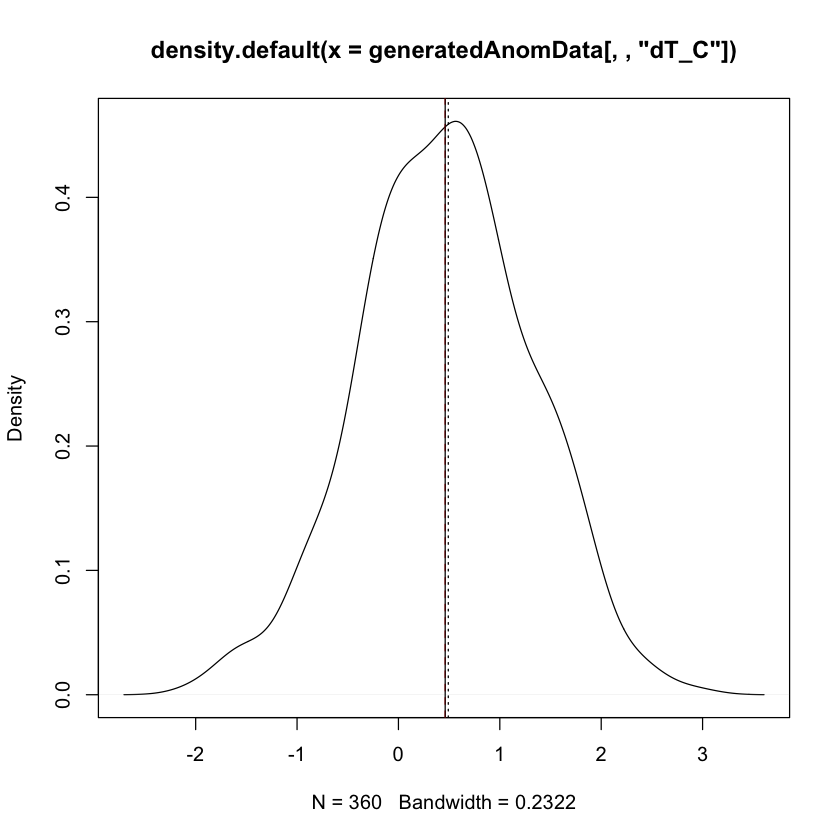

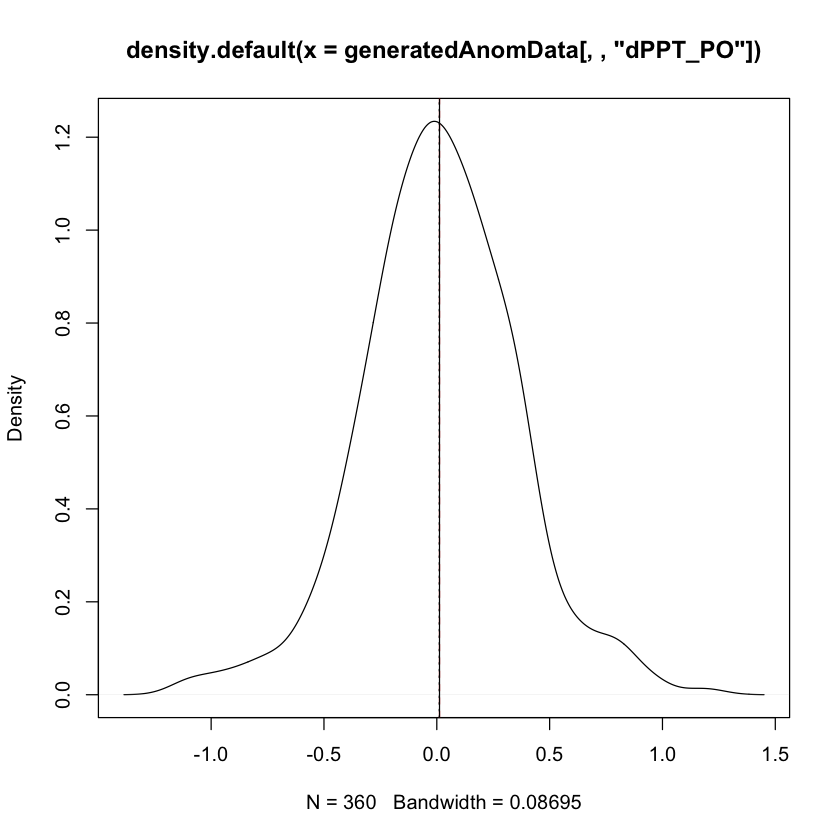

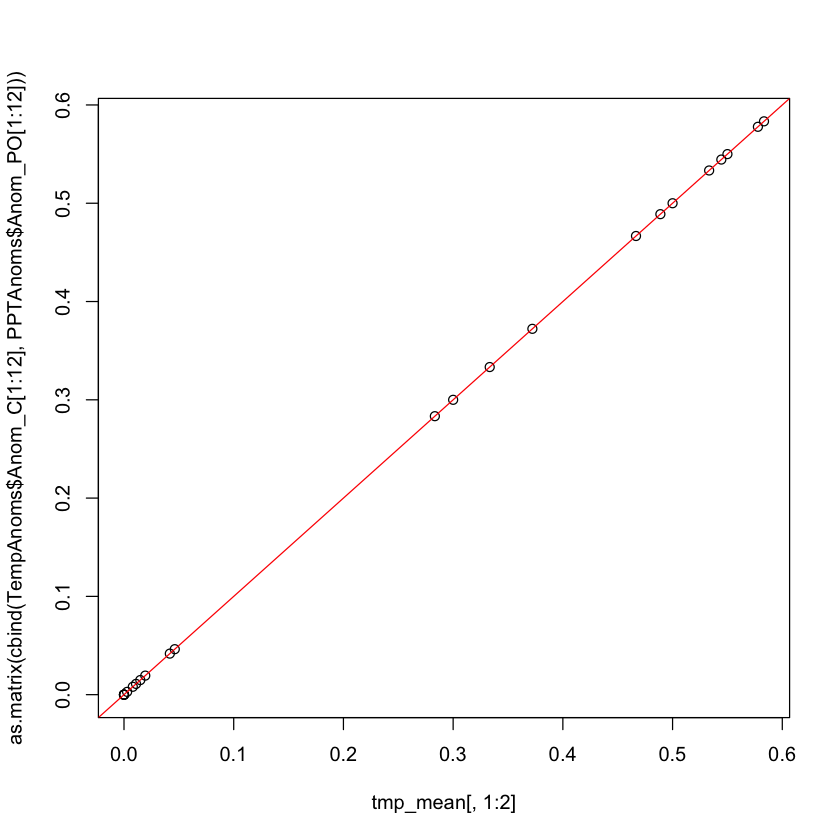

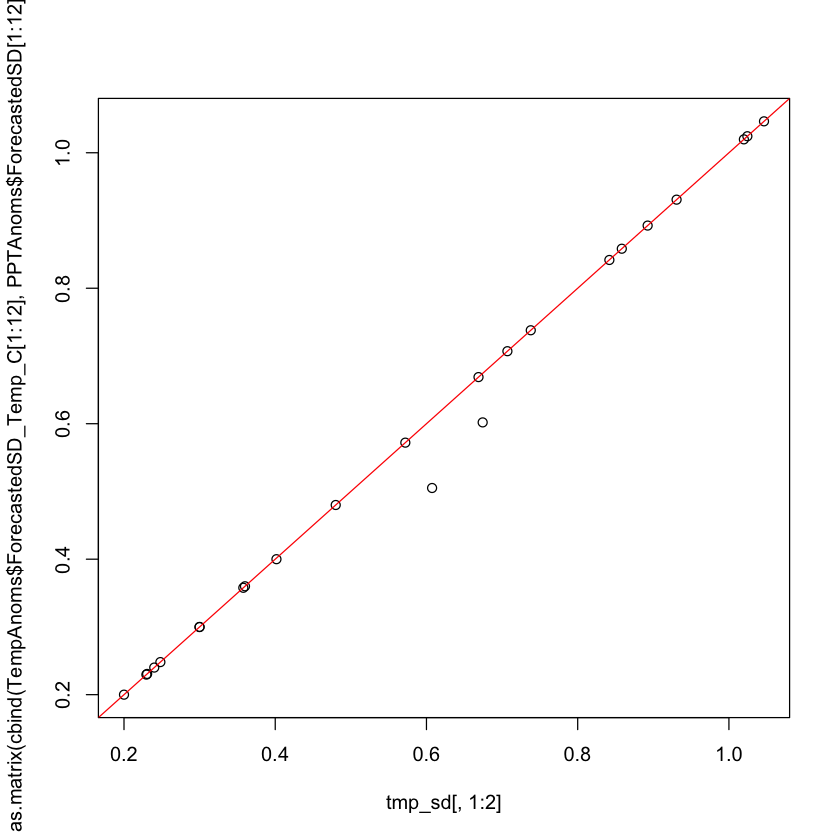

In [14]:
# function to create anomaly data - for now we will look at saved data
# generatedAnomData <- generateAnomalyData(monthlyWdata, TempAnoms, PPTAnoms, 
#                                         leads = seq_len(Nleads), Nleads = Nleads, 
#                                         n = n)



# Check that means have no bias compared to forecasted NWS means
generatedAnomData[, , "dT_C"]
plot(density(generatedAnomData[, , "dT_C"]))
abline(v = mean(TempAnoms$Anom_C), col = "red", lty = 2)
abline(v = mean(generatedAnomData[, , "dT_C"]))
abline(v = median(generatedAnomData[, , "dT_C"]), lty = 3)

plot(density(generatedAnomData[, , "dPPT_PO"]))
abline(v = mean(PPTAnoms$Anom_PO), col = "red", lty = 2)
abline(v = mean(generatedAnomData[, , "dPPT_PO"]))
abline(v = median(generatedAnomData[, , "dPPT_PO"]), lty = 3)


# Check that means have no bias compared to forecasted NWS means
tmp_mean <- apply(
  X = generatedAnomData,
  MARGIN = c(1,3),
  FUN = mean
)

plot(
  tmp_mean[,1:2],
  as.matrix(cbind(TempAnoms$Anom_C[1:12], PPTAnoms$Anom_PO[1:12]))
)
abline(0, 1, col = "red")


# Check that SDs have no bias compared to forecasted NWS SDs
tmp_sd <- apply(
  X = generatedAnomData,
  MARGIN = c(1,3),
  FUN = sd
)

plot(
  tmp_sd[,1:2],
  as.matrix(cbind(TempAnoms$ForecastedSD_Temp_C[1:12], PPTAnoms$ForecastedSD[1:12]))
)
abline(0, 1, col = "red")

# TO do - add covariances.

## Bias Correction

We apply a bias correction factor precipitation correction facotr. This bias correction is calculated by dividing the mean of the multivariate sampled distribution lead correction factor by the NWS correction factor. This bias correction is then applied to the entire distribution per lead.

In [15]:
  mean(generatedAnomData [, , "PPT_CF"])
  
  pptGenAnoms <- data.table(generatedAnomData [, , "PPT_CF"])
  pptGenAnoms$LEAD <- row.names(pptGenAnoms)
  pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
  pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
  
  PPTBiasCF <- PPTAnoms$Anom_CF / pptGenAnomsMean$MVGenMean 
  print(cbind(NWSAnom  = PPTAnoms$Anom_CF, MVAnom = pptGenAnomsMean$MVGenMean,  PPTBiasCF))
  mean( PPTAnoms$Anom_CF)
  
  generatedAnomData [, , "PPT_CF"] <- generatedAnomData [, , "PPT_CF"] * PPTBiasCF
  mean(generatedAnomData [, , "PPT_CF"] )

[1] 1.108301

       NWSAnom   MVAnom PPTBiasCF
 [1,] 1.000000 1.020239 0.9801624
 [2,] 1.000000 1.013482 0.9866973
 [3,] 1.003846 1.017020 0.9870469
 [4,] 1.016393 1.074145 0.9462350
 [5,] 1.123123 1.274211 0.8814265
 [6,] 1.000000 1.141052 0.8763844
 [7,] 1.128655 1.300021 0.8681820
 [8,] 1.048913 1.164357 0.9008515
 [9,] 1.003058 1.047030 0.9580028
[10,] 1.020080 1.078212 0.9460848
[11,] 1.000000 1.136923 0.8795671
[12,] 1.000000 1.032924 0.9681256


[1] 1.028672

[1] 1.028672

## Temperature

### Leads -  Generated lead anomaly data vs. NWS lead forecasts

[1] "Density plots of predicted LEAD Anomalies"


LEAD UVNWSmean LEAD MVGenmean LEAD AnalyticalMean NWS_Anom 
1   1   0.5648107 1    0.5500000  1   0.5500000      0.5500000
2   2   0.4677536 2    0.4666667  2   0.4666667      0.4666667
3   3   0.4491373 3    0.4888889  3   0.4888889      0.4888889
4   4   0.4662162 4    0.5000000  4   0.5000000      0.5000000
5   5   0.5609125 5    0.5777778  5   0.5777778      0.5777778
6   6   0.6010944 6    0.5833333  6   0.5833333      0.5833333
7   7   0.3517351 7    0.3333333  7   0.3333333      0.3333333
8   8   0.4149828 8    0.3722222  8   0.3722222      0.3722222
9   9   0.5488405 9    0.5444444  9   0.5444444      0.5444444
10 10   0.2916386 10   0.2833333 10   0.2833333      0.2833333
11 11   0.3079897 11   0.3000000 11   0.3000000      0.3000000
12 12   0.5225622 12   0.5333333 12   0.5333333      0.5333333

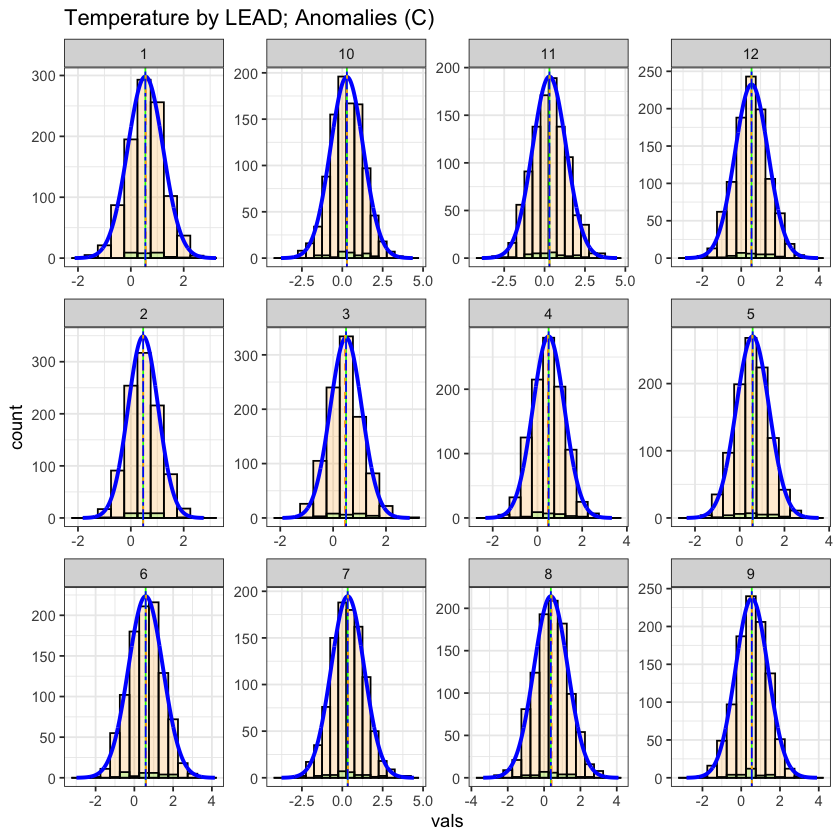

In [16]:
print('Density plots of predicted LEAD Anomalies')
# the anomaly date from NWS is the purple line. Random sample distribution of NWS data is orange
# the mean of the our generated anomlies is the dashed green line. Distribution in green
# analytical distribution in BLUE
# 1000 Future realizations as density plots

#------ Check generated anamalies against NWS anomalies
# --------- 1: NWS random univariate sample (ORANGE)
tempNWSDensity <- TempAnoms[,.(vals = rnorm(1000, mean = Anom_C, sd = ForecastedSD_Temp_C)),
                            .(LEAD)]
tempNWSDensityMean <- tempNWSDensity[,.(UVNWSmean = mean(vals)), .(LEAD)]

# ---------- 2: Generated multivariate anomalies (GREEN)
tempGenAnoms <- data.table(generatedAnomData[, , "dT_C"])
tempGenAnoms$LEAD <- row.names(tempGenAnoms)
#tempGenAnoms$LEAD <- factor(tempGenAnoms$LEAD, levels = c(1:12))
tempGenAnoms <- melt(tempGenAnoms, id.vars = 'LEAD')
tempGenAnomsMean <- tempGenAnoms[,.(MVGenmean = mean(value)),.(LEAD)]

# ----------- 3: Analytical sample (BLUE)
nobs = 1000
tempAnalyticalDensity <- data.frame()

for(L in 1:12){
    z <- subset(TempAnoms, LEAD == L)
    
    meanL <- z$Anom_C
    sdL <- z$ForecastedSD_Temp_C
  
    x <-  seq(meanL - (sdL * 4), 
              meanL + (sdL * 4), length = nobs)
    
    y <-  dnorm(x, mean = z$Anom_C, sd = z$ForecastedSD_Temp_C) 
    
    data <- data.frame(x = x, y = y, 
                       LEAD = L, mean = meanL, sd =sdL )
    
    tempAnalyticalDensity <- rbind(tempAnalyticalDensity, data)
  }

tempAnalyticalDensityMean <-setDT(tempAnalyticalDensity)[,.(AnalyticalMean = mean(x)),.(LEAD)]


# data.table
AllTempMeans <- cbind(tempNWSDensityMean, tempGenAnomsMean, tempAnalyticalDensityMean, NWS_Anom = TempAnoms$Anom_C)
AllTempMeans

# plot

bw <- .5
tempAnalyticalDensity$y_scale <- tempAnalyticalDensity$y * bw * nobs

ggplot() +
  
  geom_histogram(data = tempNWSDensity, aes(x = vals), color = 'black', alpha=.2, fill="orange", binwidth = bw) +
  geom_histogram(data = tempGenAnoms, aes(x = value),color = 'black', alpha=.2, fill="green", binwidth = bw) +
  geom_line(data = tempAnalyticalDensity, aes(x = x, y = y_scale), color = 'blue',  size = 1.1) +
  
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Temperature by LEAD; Anomalies (C)') +
  
  geom_vline(data = tempGenAnomsMean, aes(xintercept = MVGenmean), color = 'green')+
  geom_vline(data = tempNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange', lty = 'dashed') +
  geom_vline(data = TempAnoms, aes(xintercept = Anom_C), color = 'blue', lty = 'twodash') +
  theme_bw()


## Precipitation 

### Leads - Generated lead anomaly data vs. NWS lead forecasts

[1] "Table of NWS randomly sampled univariate values"


LEAD UVNWS_vals PO   ClimatatologicalMEAN_PPT_cm UVNWS_ForecastedVal_in
1     1    2.694231   0.49 11.9888                     7.558547              
2     1    2.130919   0.49 11.9888                     4.683223              
3     1    2.445267   0.49 11.9888                     6.201584              
4     1    1.730350   0.49 11.9888                     3.061875              
5     1    1.977728   0.49 11.9888                     4.021809              
6     1    2.091718   0.49 11.9888                     4.509079              
7     1    2.433928   0.49 11.9888                     6.143035              
8     1    2.406141   0.49 11.9888                     6.000761              
9     1    2.430030   0.49 11.9888                     6.122975              
10    1    1.780391   0.49 11.9888                     3.245309              
11    1    2.038689   0.49 11.9888                     4.278865              
12    1    1.952276   0.49 11.9888                     3.916887              
13    1    2.689750   0.49 11.9888                     7.532915              
14    1    1.889975   0.49 11.9888                     3.666029              
15    1    2.334115   0.49 11.9888                     5.639879              
16    1    1.960899   0.49 11.9888                     3.952279              
17    1    2.196582   0.49 11.9888                     4.982457              
18    1    1.481491   0.49 11.9888                     2.230309              
19    1    2.079737   0.49 11.9888                     4.456528              
20    1    1.591911   0.49 11.9888                     2.582731              
21    1    2.096036   0.49 11.9888                     4.528098              
22    1    2.336464   0.49 11.9888                     5.651469              
23    1    2.283031   0.49 11.9888                     5.390844              
24    1    1.855393   0.49 11.9888                     3.530436              
25    1    2.125092   0.49 11.9888                     4.657125              
26    1    2.386889   0.49 11.9888                     5.903180              
27    1    2.070404   0.49 11.9888                     4.415811              
28    1    1.496833   0.49 11.9888                     2.277701              
29    1    2.334626   0.49 11.9888                     5.642402              
30    1    2.120505   0.49 11.9888                     4.636631              
⋮     ⋮    ⋮          ⋮    ⋮                           ⋮                     
11971 12   2.076416   0.54 7.0104                      3.869184              
11972 12   1.543847   0.54 7.0104                      2.234946              
11973 12   1.514626   0.54 7.0104                      2.157242              
11974 12   1.918599   0.54 7.0104                      3.342294              
11975 12   1.630552   0.54 7.0104                      2.472934              
11976 12   1.955169   0.54 7.0104                      3.461229              
11977 12   1.643597   0.54 7.0104                      2.509696              
11978 12   1.530507   0.54 7.0104                      2.199315              
11979 12   1.731496   0.54 7.0104                      2.763894              
11980 12   2.007734   0.54 7.0104                      3.635525              
11981 12   1.905347   0.54 7.0104                      3.299669              
11982 12   2.221006   0.54 7.0104                      4.382872              
11983 12   1.906453   0.54 7.0104                      3.303217              
11984 12   1.659031   0.54 7.0104                      2.553512              
11985 12   2.036399   0.54 7.0104                      3.732228              
11986 12   1.601685   0.54 7.0104                      2.392470              
11987 12   1.518561   0.54 7.0104                      2.167634              
11988 12   1.383990   0.54 7.0104                      1.825397              
11989 12   1.970432   0.54 7.0104                      3.511433              
11990 12   2.235269   0.54 7

[1] "Analytical Distribution"


x         x_in      x_cm     x_CF      y            y_in        
1     0.9391024 0.8796546 2.234323 0.1863675 0.0004461008 1.452473e-07
2     0.9415048 0.8842532 2.246003 0.1873418 0.0004606068 1.550494e-07
3     0.9439072 0.8888640 2.257715 0.1883186 0.0004755541 1.654914e-07
4     0.9463096 0.8934871 2.269457 0.1892981 0.0004909549 1.766134e-07
5     0.9487120 0.8981224 2.281231 0.1902802 0.0005068220 1.884583e-07
6     0.9511144 0.9027699 2.293036 0.1912648 0.0005231684 2.010713e-07
7     0.9535168 0.9074297 2.304871 0.1922521 0.0005400073 2.145003e-07
8     0.9559192 0.9121017 2.316738 0.1932419 0.0005573525 2.287962e-07
9     0.9583216 0.9167860 2.328636 0.1942343 0.0005752179 2.440131e-07
10    0.9607240 0.9214824 2.340565 0.1952293 0.0005936179 2.602079e-07
11    0.9631264 0.9261912 2.352526 0.1962269 0.0006125673 2.774412e-07
12    0.9655288 0.9309121 2.364517 0.1972271 0.0006320809 2.957772e-07
13    0.9679313 0.9356453 2.376539 0.1982299 0.0006521744 3.152837e-07
14    0.9703337 0.9403908 2.388593 0.1992353 0.0006728635 3.360327e-07
15    0.9727361 0.9451485 2.400677 0.2002433 0.0006941643 3.581003e-07
16    0.9751385 0.9499184 2.412793 0.2012539 0.0007160936 3.815672e-07
17    0.9775409 0.9547006 2.424939 0.2022671 0.0007386683 4.065187e-07
18    0.9799433 0.9594950 2.437117 0.2032828 0.0007619057 4.330451e-07
19    0.9823457 0.9643017 2.449326 0.2043012 0.0007858238 4.612421e-07
20    0.9847481 0.9691206 2.461566 0.2053222 0.0008104408 4.912109e-07
21    0.9871505 0.9739518 2.473838 0.2063457 0.0008357753 5.230583e-07
22    0.9895529 0.9787952 2.486140 0.2073719 0.0008618465 5.568977e-07
23    0.9919553 0.9836509 2.498473 0.2084006 0.0008886740 5.928487e-07
24    0.9943577 0.9885189 2.510838 0.2094320 0.0009162779 6.310380e-07
25    0.9967601 0.9933991 2.523234 0.2104659 0.0009446785 6.715994e-07
26    0.9991625 0.9982915 2.535660 0.2115024 0.0009738970 7.146744e-07
27    1.0015649 1.0031962 2.548118 0.2125416 0.0010039549 7.604127e-07
28    1.0039673 1.0081132 2.560608 0.2135833 0.0010348740 8.089723e-07
29    1.0063697 1.0130425 2.573128 0.2146276 0.0010666770 8.605202e-07
30    1.0087721 1.0179840 2.585679 0.2156746 0.0010993868 9.152330e-07
⋮     ⋮         ⋮         ⋮        ⋮         ⋮            ⋮           
11971 3.086575  8.061921  20.47728 2.920986  0.0009161557 2.366013e-06
11972 3.089458  8.075871  20.51271 2.926040  0.0008888975 2.237306e-06
11973 3.092341  8.089832  20.54817 2.931098  0.0008623950 2.115348e-06
11974 3.095224  8.103804  20.58366 2.936161  0.0008366290 1.999802e-06
11975 3.098106  8.117787  20.61918 2.941227  0.0008115809 1.890342e-06
11976 3.100989  8.131781  20.65472 2.946297  0.0007872321 1.786661e-06
11977 3.103872  8.145786  20.69030 2.951372  0.0007635649 1.688467e-06
11978 3.106755  8.159803  20.72590 2.956450  0.0007405617 1.595479e-06
11979 3.109638  8.173830  20.76153 2.961533  0.0007182055 1.507434e-06
11980 3.112521  8.187869  20.79719 2.966619  0.0006964794 1.424078e-06
11981 3.115404  8.201918  20.83287 2.971709  0.0006753673 1.345172e-06
11982 3.118287  8.215979  20.86859 2.976804  0.0006548532 1.270487e-06
11983 3.121169  8.230050  20.90433 2.981902  0.0006349215 1.199806e-06
11984 3.124052  8.244133  20.94010 2.987005  0.0006155569 1.132923e-06
11985 3.126935  8.258227  20.97590 2.992111  0.0005967447 1.069641e-06
11986 3.129818  8.272332  21.01172 2.997222  0.0005784703 1.009774e-06
11987 3.132701  8.286448  21.04758 3.002336  0.0005607195 9.531444e-07
11988 3.135584  8.300575  21.08346 3.007455  0.0005434787 8.995838e-07
11989 3.138467  8.314713  21.11937 3.012577  0.0005267341 8.489322e-07
11990 3.141350  8.328863  21.15531 3.017704  0.0005104727 8.010375e-07
11991 3.144233  8.343023  21.19128 3.022834  0.0004946816 7.557551e-07
11992 3.147115  8.357194  21.22727 3.027969  0.0004793483 7.129478e-07
11993 3.149998  8.371377  21.26330 3.033108  0.0004644604 6.724853e-07
11994 3.152881  8.385570  21.29935 3.038250  0.0004500061 6.342439e-07
11995 3.155764  8.399775  21.3

[1] "Multivariate sampled precipitation values - total forecast amount in transformed units"
[1] "Table of Means - Total Forecasted PPT (Transformed Units)"


LEAD UVNWSmean LEAD MVGenMean LEAD AnalyticalMean_PO NWS_Forecast_Mean_PO
1   1   2.136132  1    2.139102   1   2.139102          2.139102            
2   2   2.955713  2    2.949649   2   2.949649          2.949649            
3   3   3.062755  3    3.076210   3   3.076210          3.076210            
4   4   1.678627  4    1.691286   4   1.691286          1.691286            
5   5   1.444638  5    1.446785   5   1.446785          1.446785            
6   6   1.386355  6    1.380380   6   1.380380          1.380380            
7   7   1.392348  7    1.401673   7   1.401673          1.401673            
8   8   1.453210  8    1.459636   8   1.459636          1.459636            
9   9   1.800003  9    1.832718   9   1.832718          1.832718            
10 10   1.579743  10   1.564300  10   1.564300          1.564300            
11 11   1.114873  11   1.109296  11   1.109296          1.109296            
12 12   1.712991  12   1.730178  12   1.730178          1.730178            
   PO  
1  0.49
2  0.61
3  0.68
4  0.40
5  0.28
6  0.27
7  0.25
8  0.28
9  0.51
10 0.48
11 0.29
12 0.54

[1] "Table of Medians - Forecasted PPT (Transformed Units)"


LEAD UVNWSmedian LEAD MVGenMed LEAD AnalyticalMedian_PO NWS_Forecast_Mean_PO
1   1   2.130765    1    2.095797  1   2.139102            2.139102            
2   2   2.971399    2    3.027484  2   2.949649            2.949649            
3   3   3.064257    3    3.020122  3   3.076210            3.076210            
4   4   1.671134    4    1.649242  4   1.691286            1.691286            
5   5   1.446019    5    1.474340  5   1.446785            1.446785            
6   6   1.383851    6    1.372548  6   1.380380            1.380380            
7   7   1.395507    7    1.406970  7   1.401673            1.401673            
8   8   1.458503    8    1.462194  8   1.459636            1.459636            
9   9   1.799222    9    1.845726  9   1.832718            1.832718            
10 10   1.573433    10   1.523638 10   1.564300            1.564300            
11 11   1.110808    11   1.088213 11   1.109296            1.109296            
12 12   1.721202    12   1.739149 12   1.730178            1.730178            
   PO  
1  0.49
2  0.61
3  0.68
4  0.40
5  0.28
6  0.27
7  0.25
8  0.28
9  0.51
10 0.48
11 0.29
12 0.54

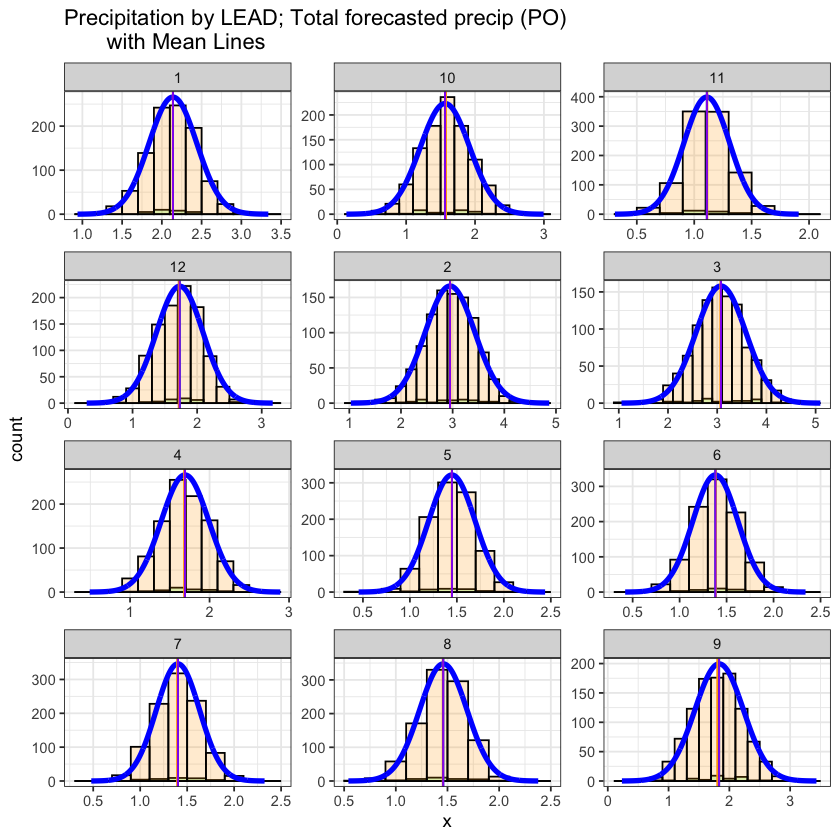

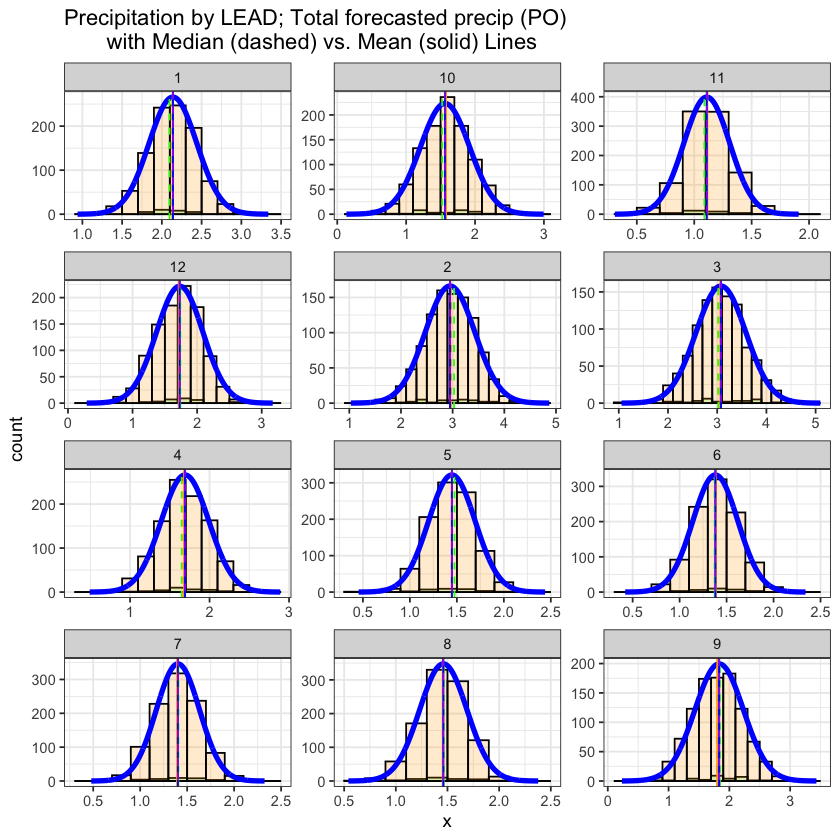

In [17]:
 # --------- 1: NWS random univariate sample (orange)
# --------- 1: NWS random univariate sample (orange)
s <- 1000
pptNWSDensity <- PPTAnoms[,.(UVNWS_vals = rnorm(s, mean = ForecastedMEAN_PPT_PO, sd = ForecastedSD)), .(LEAD)]
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_vals)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_vals)), .(LEAD)]

# conversions!
pptNWSDensity <- merge(pptNWSDensity, PPTAnoms[,c('LEAD', 'PO', 'ClimatatologicalMEAN_PPT_cm')])
pptNWSDensity$UVNWS_ForecastedVal_in <- (pptNWSDensity$UVNWS_vals) ^ (1/pptNWSDensity$PO)
pptNWSDensity$UVNWS_ForecastedVal_cm <- pptNWSDensity$UVNWS_ForecastedVal_in * 2.54
pptNWSDensity$UVNWS_PPT_CF_MEAN <- pptNWSDensity$UVNWS_ForecastedVal_cm / pptNWSDensity$ClimatatologicalMEAN_PPT_cm

print('Table of NWS randomly sampled univariate values')
pptNWSDensity

# ---------- 3: Analytical distribution (BLUE)
pptAnalyticalDensity <- data.frame()

for(L in 1:12) {
  z <- subset(PPTAnoms, LEAD == L)
  zz <- subset(pptNWSDensity, LEAD == L)
  
  # sequence of values within 4 sds of the mean
  climmean <- z$ClimatatologicalMEAN_PPT_cm
  meanL <- z$ForecastedMEAN_PPT_PO
  sdL <- z$ForecastedSD
  PO <- z$PO
  
  x <-  seq(meanL - (sdL * 4), 
            meanL + (sdL * 4), length = s)
  
  x_in <-  x ^ (1/PO)
  x_cm <- x_in * 2.54
  x_CF <- x_cm/climmean
  
  # predictions of curve
  y <-  dnorm(x, mean = meanL, sd = sdL)
  # convert
  y_in <- y ^ (1/PO)
  y_cm <- y_in * 2.54
  y_CF <- y_cm/climmean
  
  data <- data.frame(x = x, x_in = x_in, x_cm = x_cm, x_CF = x_CF,
                     y = y,  y_in = y_in, y_cm = y_cm, y_CF = y_CF,
                     LEAD = L, mean = meanL, sd =sdL, PO = PO )
  
  pptAnalyticalDensity <- rbind(pptAnalyticalDensity, data)
  
}

print('Analytical Distribution')
pptAnalyticalDensity
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_PO = mean(x)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_PO = median(x)),.(LEAD)]


# ---------- 2: Generated multivariate anomalies (Green)
# transformed forecast
pptGenAnoms <- data.table(generatedAnomData[, , "PT_GenForecasted_PO"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms$LEAD <- factor(pptGenAnoms$LEAD, levels = c(1:12))
print('Multivariate sampled precipitation values - total forecast amount in transformed units')
#pptGenAnoms

pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]


# Make Table of means 
AllPPTMeans_PO <- cbind(pptNWSDensityMean, pptGenAnomsMean, pptAnalyticalDensityMean, NWS_Forecast_Mean_PO = PPTAnoms$ForecastedMEAN_PPT_PO, PO = PPTAnoms$PO)
AllPPTMedians_PO <- cbind(pptNWSDensityMedian, pptGenAnomsMedian, pptAnalyticalDensityMedian, NWS_Forecast_Mean_PO = PPTAnoms$ForecastedMEAN_PPT_PO, PO = PPTAnoms$PO)

# scale!
bw1 <- .2 # binwidth .. important for scaling y axis to a count
pptAnalyticalDensity$y_scale <- pptAnalyticalDensity$y * bw1 * s
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_PO = mean(x)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_PO = median(x)),.(LEAD)]

p1 <- ggplot(pptAnalyticalDensity, aes(x = x)) + 
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw1) +
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_vals), color = 'black', fill = 'orange', alpha = .2, binwidth = bw1) +
  geom_line(aes(y = y_scale), color = 'blue', size = 1.5) + 
  
  facet_wrap(~ LEAD, scales = 'free', nrow =4) +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO)') +
  theme_bw()

p1Means <- p1 +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO) 
       with Mean Lines') +
  
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange') +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_PO), color = 'blue') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_PO), color = 'purple') 

p1Medians <- p1 +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO)
       with Median (dashed) vs. Mean (solid) Lines') +
  # these are means
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange') +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_PO), color = 'blue') +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_PO), color = 'purple') +

  # these are medians
 geom_vline(data = pptGenAnomsMedian, aes(xintercept = MVGenMed), color = 'green', lty = 'dashed')+
  geom_vline(data = pptNWSDensityMedian, aes(xintercept = UVNWSmedian), color = 'orange', lty = 'dashed') +
  geom_vline(data = pptAnalyticalDensityMedian, aes(xintercept = AnalyticalMedian_PO), color = 'blue', lty = 'dashed')

print('Table of Means - Total Forecasted PPT (Transformed Units)')
#PPTAnoms
AllPPTMeans_PO
print(p1Means)
print('Table of Medians - Forecasted PPT (Transformed Units)')
AllPPTMedians_PO
print(p1Medians)


[1] "Density plots of predicted LEAD Anomalies"
[1] "Table of NWS randomly sampled univariate values"


LEAD UVNWS_vals PO   ClimatatologicalMEAN_PPT_cm UVNWS_ForecastedVal_in
1   1    1.852018   0.49 11.9888                     3.517341              
2   1    2.205166   0.49 11.9888                     5.022278              
3   1    1.816132   0.49 11.9888                     3.379655              
4   1    2.281921   0.49 11.9888                     5.385496              
5   1    1.720015   0.49 11.9888                     3.024672              
6   1    2.704546   0.49 11.9888                     7.617725              
7   1    2.169285   0.49 11.9888                     4.856913              
8   1    2.463548   0.49 11.9888                     6.296570              
9   1    1.992131   0.49 11.9888                     4.081810              
10  1    1.932461   0.49 11.9888                     3.836183              
11  1    1.877506   0.49 11.9888                     3.616838              
12  1    2.440400   0.49 11.9888                     6.176419              
13  1    1.757019   0.49 11.9888                     3.158957              
14  1    2.207657   0.49 11.9888                     5.033861              
15  1    2.095833   0.49 11.9888                     4.527205              
16  1    2.351039   0.49 11.9888                     5.723650              
17  1    2.777568   0.49 11.9888                     8.043371              
18  1    1.969628   0.49 11.9888                     3.988266              
19  1    1.774176   0.49 11.9888                     3.222231              
20  1    1.761284   0.49 11.9888                     3.174625              
21  1    2.213239   0.49 11.9888                     5.059870              
22  1    2.118073   0.49 11.9888                     4.625785              
23  1    1.917312   0.49 11.9888                     3.775063              
24  1    2.059120   0.49 11.9888                     4.366833              
25  1    2.384381   0.49 11.9888                     5.890530              
26  1    1.837677   0.49 11.9888                     3.461981              
27  1    2.537035   0.49 11.9888                     6.685839              
28  1    2.425285   0.49 11.9888                     6.098598              
29  1    2.409128   0.49 11.9888                     6.015972              
30  1    2.632961   0.49 11.9888                     7.211903              
⋮   ⋮    ⋮          ⋮    ⋮                           ⋮                     
331 12   1.9584830  0.54 7.0104                      3.4721002             
332 12   1.8195537  0.54 7.0104                      3.0298174             
333 12   1.1085995  0.54 7.0104                      1.2103643             
334 12   1.4466789  0.54 7.0104                      1.9814607             
335 12   1.7643027  0.54 7.0104                      2.8616523             
336 12   1.5646458  0.54 7.0104                      2.2910244             
337 12   0.9560928  0.54 7.0104                      0.9202144             
338 12   1.3164899  0.54 7.0104                      1.6639627             
339 12   1.7749861  0.54 7.0104                      2.8938241             
340 12   0.7832942  0.54 7.0104                      0.6361576             
341 12   1.2876796  0.54 7.0104                      1.5971577             
342 12   1.6606566  0.54 7.0104                      2.5581478             
343 12   1.9593712  0.54 7.0104                      3.4750167             
344 12   1.5023421  0.54 7.0104                      2.1249547             
345 12   2.2093871  0.54 7.0104                      4.3405065             
346 12   1.6277757  0.54 7.0104                      2.4651411             
347 12   1.7675287  0.54 7.0104                      2.8713497             
348 12   1.4510230  0.54 7.0104                      1.9924931             
349 12   1.7744569  0.54 7.0104                      2.8922267             
350 12   1.2815984  0.54 7.0104                      1.5832179             
351 12   1.6462082  0.54 7.0104                     

[1] "Analytical Distribution"


x         x_in       x_cm       x_CF       y            y_in        
1   0.9391024  0.8796546  2.234323  0.1863675  0.0004461008 1.452473e-07
2   1.0218610  1.0451221  2.654610  0.2214242  0.0012945820 1.277576e-06
3   1.1046197  1.2251502  3.111881  0.2595657  0.0034815804 9.620933e-06
4   1.1873783  1.4197852  3.606255  0.3008020  0.0086770787 6.202961e-05
5   1.2701369  1.6290705  4.137839  0.3451420  0.0200410687 3.423989e-04
6   1.3528955  1.8530462  4.706737  0.3925945  0.0428961645 1.618144e-03
7   1.4356541  2.0917504  5.313046  0.4431675  0.0850876027 6.547170e-03
8   1.5184128  2.3452188  5.956856  0.4968684  0.1564099421 2.267992e-02
9   1.6011714  2.6134852  6.638252  0.5537045  0.2664481224 6.726373e-02
10  1.6839300  2.8965817  7.357318  0.6136826  0.4206406257 1.707937e-01
11  1.7666886  3.1945390  8.114129  0.6768091  0.6154035639 3.712909e-01
12  1.8494472  3.5073860  8.908761  0.7430903  0.8343706920 6.910481e-01
13  1.9322059  3.8351508  9.741283  0.8125319  1.0483548676 1.101168e+00
14  2.0149645  4.1778599 10.611764  0.8851398  1.2206968753 1.502279e+00
15  2.0977231  4.5355390 11.520269  0.9609193  1.3172178014 1.754685e+00
16  2.1804817  4.9082127 12.466860  1.0398756  1.3172178014 1.754685e+00
17  2.2632404  5.2959047 13.451598  1.1220137  1.2206968753 1.502279e+00
18  2.3459990  5.6986378 14.474540  1.2073385  1.0483548676 1.101168e+00
19  2.4287576  6.1164342 15.535743  1.2958547  0.8343706920 6.910481e-01
20  2.5115162  6.5493152 16.635261  1.3875668  0.6154035639 3.712909e-01
21  2.5942748  6.9973013 17.773145  1.4824791  0.4206406257 1.707937e-01
22  2.6770335  7.4604127 18.949448  1.5805959  0.2664481224 6.726373e-02
23  2.7597921  7.9386687 20.164219  1.6819213  0.1564099421 2.267992e-02
24  2.8425507  8.4320882 21.417504  1.7864594  0.0850876027 6.547170e-03
25  2.9253093  8.9406894 22.709351  1.8942139  0.0428961645 1.618144e-03
26  3.0080679  9.4644902 24.039805  2.0051886  0.0200410687 3.423989e-04
27  3.0908266 10.0035078 25.408910  2.1193873  0.0086770787 6.202961e-05
28  3.1735852 10.5577592 26.816708  2.2368134  0.0034815804 9.620933e-06
29  3.2563438 11.1272608 28.263242  2.3574705  0.0012945820 1.277576e-06
30  3.3391024 11.7120286 29.748553  2.4813620  0.0004461008 1.452473e-07
⋮   ⋮         ⋮          ⋮          ⋮          ⋮            ⋮           
331 0.2901785 0.1011429   0.2569030 0.03664599 0.0003717506 4.452606e-07
332 0.3894888 0.1744445   0.4430891 0.06320455 0.0010788184 3.202284e-06
333 0.4887992 0.2656536   0.6747601 0.09625129 0.0029013170 2.000333e-05
334 0.5881095 0.3741715   0.9503957 0.13556940 0.0072308989 1.085279e-04
335 0.6874199 0.4995275   1.2687998 0.18098822 0.0167008906 5.114193e-04
336 0.7867302 0.6413349   1.6289906 0.23236771 0.0357468037 2.093195e-03
337 0.8860405 0.7992669   2.0301380 0.28958947 0.0709063356 7.441131e-03
338 0.9853509 0.9730414   2.4715252 0.35255123 0.1303416184 2.297550e-02
339 1.0846612 1.1624104   2.9525224 0.42116318 0.2220401020 6.161519e-02
340 1.1839716 1.3671532   3.4725691 0.49534536 0.3505338548 1.435183e-01
341 1.2832819 1.5870713   4.0311611 0.57502583 0.5128363032 2.903512e-01
342 1.3825923 1.8219845   4.6278406 0.66013930 0.6953089100 5.101955e-01
343 1.4819026 2.0717279   5.2621888 0.75062604 0.8736290563 7.786574e-01
344 1.5812130 2.3361497   5.9338203 0.84643106 1.0172473960 1.032174e+00
345 1.6805233 2.6151095   6.6423782 0.94750346 1.0976815011 1.188382e+00
346 1.7798336 2.9084766   7.3875306 1.05379588 1.0976815011 1.188382e+00
347 1.8791440 3.2161289   8.1689673 1.16526409 1.0172473960 1.032174e+00
348 1.9784543 3.5379518   8.9863975 1.28186659 0.8736290563 7.786574e-01
349 2.0777647 3.8738376   9.8395474 1.40356434 0.6953089100 5.101955e-01
350 2.1770750 4.2236845  10.7281587 1.53032048 0.5128363032 2.903512e-01
351 2.2763854 4.5873964  11.6519869 1.66210015 0.3505338548 1.435183e-01
352 2.3756957 4.9648818  12.6107998 1.79887022 0.2220401020 6.161519e-02
353 2.4750061 5.3560539  13.6043769 1.94059924 0.1303416184 2.

[1] "Multivariate sampled precipitation values - total forecast amount in transformed units"
[1] "Table of Means - Total Forecasted PPT (Transformed Units)"


LEAD UVNWSmean MVGenMean AnalyticalMean NWS_Forecast_Mean_PO PO  
1   1   2.156118  2.139102  2.139102       2.139102             0.49
2   2   2.834131  2.949649  2.949649       2.949649             0.61
3   3   3.169368  3.076210  3.076210       3.076210             0.68
4   4   1.743004  1.691286  1.691286       1.691286             0.40
5   5   1.440400  1.446785  1.446785       1.446785             0.28
6   6   1.329072  1.380380  1.380380       1.380380             0.27
7   7   1.455596  1.401673  1.401673       1.401673             0.25
8   8   1.400731  1.459636  1.459636       1.459636             0.28
9   9   1.919680  1.832718  1.832718       1.832718             0.51
10 10   1.471834  1.564300  1.564300       1.564300             0.48
11 11   1.126745  1.109296  1.109296       1.109296             0.29
12 12   1.644102  1.730178  1.730178       1.730178             0.54

[1] "Table of Medians - Forecasted PPT (Transformed Units)"


LEAD UVNWSmedian MVGenMedian AnalyticalMedian NWS_Forecast_Mean_PO PO  
1   1   2.143679    2.095797    2.139102         2.139102             0.49
2   2   2.866495    3.027484    2.949649         2.949649             0.61
3   3   3.168064    3.020122    3.076210         3.076210             0.68
4   4   1.760016    1.649242    1.691286         1.691286             0.40
5   5   1.455894    1.474340    1.446785         1.446785             0.28
6   6   1.365042    1.372548    1.380380         1.380380             0.27
7   7   1.470182    1.406970    1.401673         1.401673             0.25
8   8   1.388845    1.462194    1.459636         1.459636             0.28
9   9   1.934222    1.845726    1.832718         1.832718             0.51
10 10   1.498228    1.523638    1.564300         1.564300             0.48
11 11   1.206172    1.088213    1.109296         1.109296             0.29
12 12   1.658331    1.739149    1.730178         1.730178             0.54

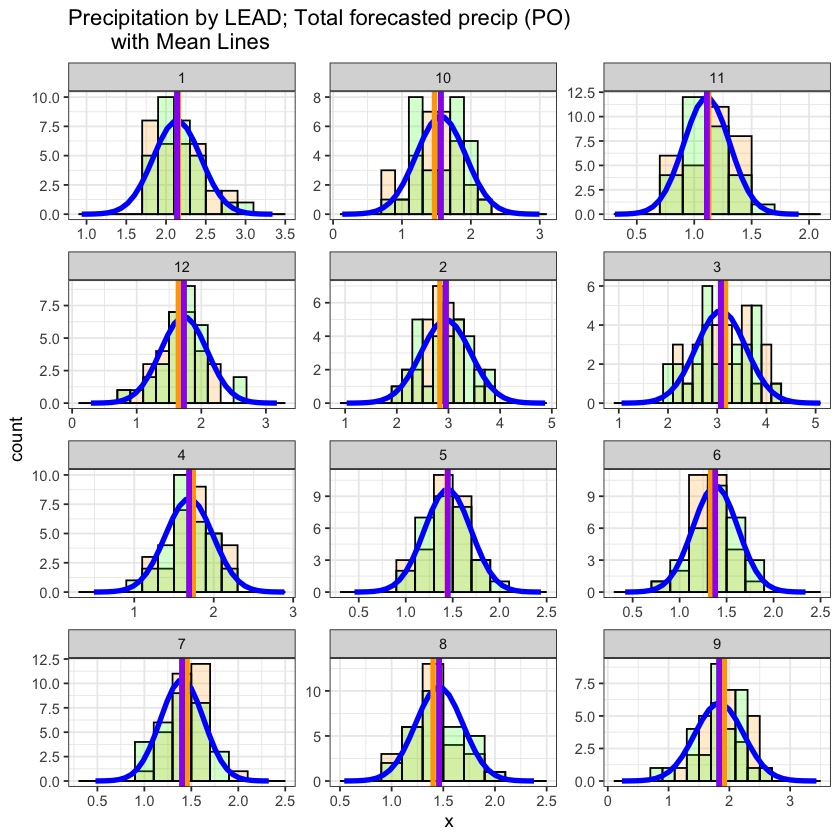

[1] "Table of Means - Total Forecasted PPT (cm)"


LEAD UVNWSmean MVGenMean AnalyticalMean NWS_Forecast_Mean_cm
1   1   12.435539 11.9888   13.415607      11.9888             
2   2   14.154270 14.9606   16.158723      14.9606             
3   3   13.998470 13.2588   13.978656      13.2588             
4   4   10.651168  9.4488   12.600072       9.4488             
5   5   10.415572  9.4996   16.978849       9.4996             
6   6    8.046416  8.3820   15.839648       8.3820             
7   7   12.427012  9.8044   19.301350       9.8044             
8   8    9.488314  9.8044   16.276416       9.8044             
9   9    9.375873  8.3312   10.466506       8.3312             
10 10    6.050678  6.4516    8.614481       6.4516             
11 11    4.326929  3.6322    6.525411       3.6322             
12 12    6.607862  7.0104    8.385130       7.0104

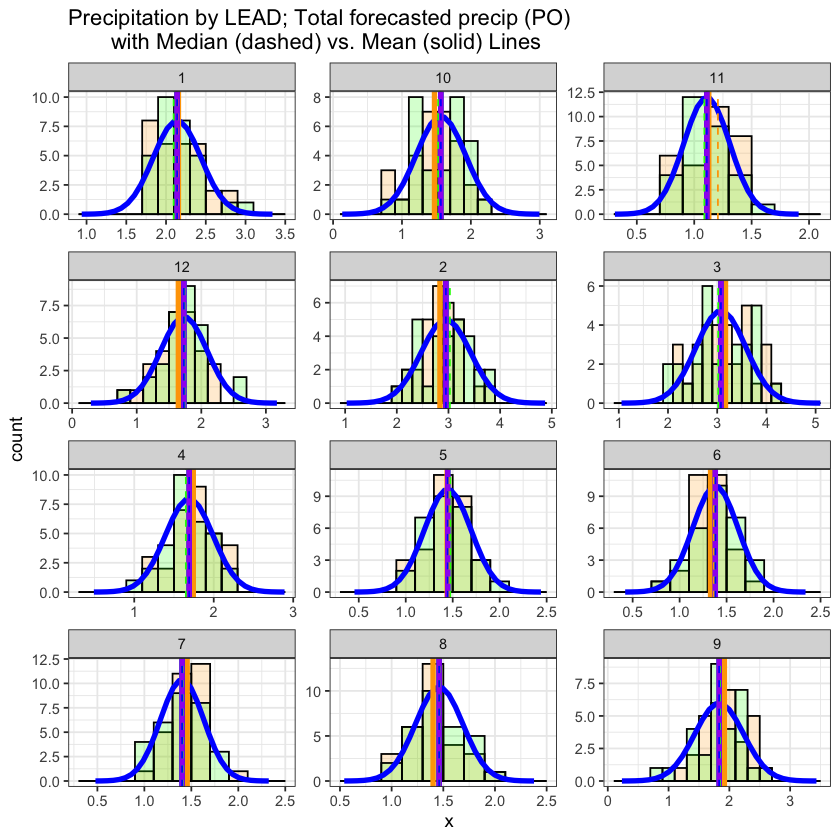

[1] "Table of Medians - Total Forecasted PPT (cm)"


LEAD UVNWSmedian MVGenMedian AnalyticalMedian NWS_Forecast_Mean_cm
1   1   12.043027   11.272372   11.993565        11.9888             
2   2   14.275453   15.405601   14.964550        14.9606             
3   3   13.845316   12.740075   13.261153        13.2588             
4   4   10.438295    8.396406    9.459391         9.4488             
5   5    9.717833    8.956846    9.524005         9.4996             
6   6    8.050726    7.192867    8.406137         8.3820             
7   7   11.869025    8.645153    9.834694         9.8044             
8   8    8.209798    8.887765    9.825593         9.8044             
9   9    9.260005    8.092822    8.338312         8.3312             
10 10    5.896914    5.778016    6.458846         6.4516             
11 11    4.847933    2.990293    3.641682         3.6322             
12 12    6.480865    6.852307    7.014954         7.0104

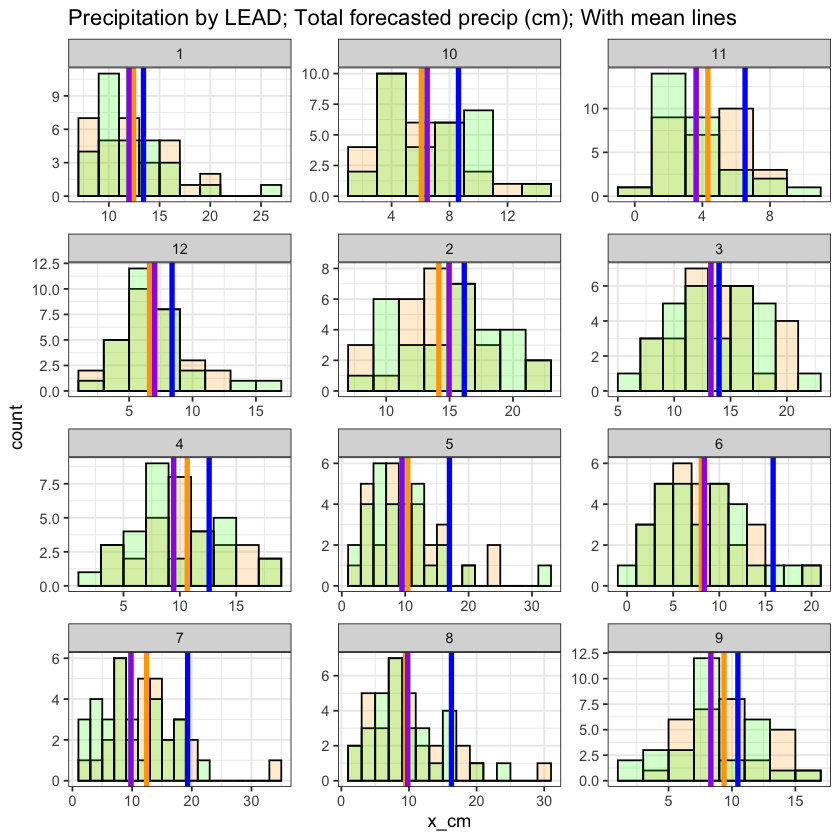

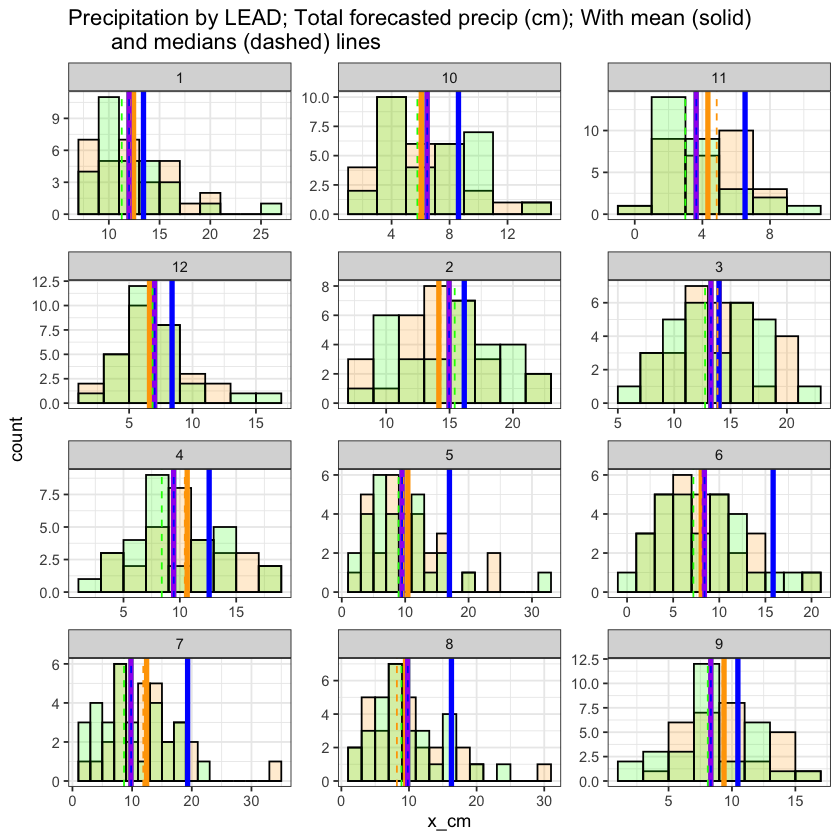

In [18]:
print('Density plots of predicted LEAD Anomalies')

PPTAnoms <- fread('ExampleData/PPTAnoms.csv')
generatedAnomData <- readRDS('ExampleData/generatedAnomData_PPTBiasCorrected')

# PRECIP
# ----------------------------------------------------------------------------------
# --------- 1: NWS random univariate sample (orange)
s <- 30

pptNWSDensity <- PPTAnoms[,.(UVNWS_vals = rnorm(s, mean = ForecastedMEAN_PPT_PO, sd = ForecastedSD)), .(LEAD)]
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_vals)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_vals)), .(LEAD)]

# conversions!
pptNWSDensity <- merge(pptNWSDensity, PPTAnoms[,c('LEAD', 'PO', 'ClimatatologicalMEAN_PPT_cm')])
pptNWSDensity$UVNWS_ForecastedVal_in <- (pptNWSDensity$UVNWS_vals) ^ (1/pptNWSDensity$PO)
pptNWSDensity$UVNWS_ForecastedVal_cm <- pptNWSDensity$UVNWS_ForecastedVal_in * 2.54
pptNWSDensity$UVNWS_PPT_CF <- pptNWSDensity$UVNWS_ForecastedVal_cm / pptNWSDensity$ClimatatologicalMEAN_PPT_cm

print('Table of NWS randomly sampled univariate values')
pptNWSDensity

# ---------- 3: Analytical distribution (BLUE)
pptAnalyticalDensity <- data.frame()

for(L in 1:12) {
  z <- subset(PPTAnoms, LEAD == L)

  # sequence of values within 4 sds of the mean
  climmean <- z$ClimatatologicalMEAN_PPT_cm
  meanL <- z$ForecastedMEAN_PPT_PO
  sdL <- z$ForecastedSD
  PO <- z$PO
  
  x <-  seq(meanL - (sdL * 4), 
            meanL + (sdL * 4), length = s)
  
  x_in <-  x ^ (1/PO)
  x_cm <- x_in * 2.54
  x_CF <- x_cm/climmean
  
  # predictions of curve
  y <-  dnorm(x, mean = meanL, sd = sdL)
  # convert
  y_in <- y ^ (1/PO)
  y_cm <- y_in * 2.54
  y_CF <- y_cm/climmean
  
  data <- data.frame(x = x, x_in = x_in, x_cm = x_cm, x_CF = x_CF,
                     y = y,  y_in = y_in, y_cm = y_cm, y_CF = y_CF,
                     LEAD = L, mean = meanL, sd =sdL, PO = PO )
  
  pptAnalyticalDensity <- rbind(pptAnalyticalDensity, data)
  
}

print('Analytical Distribution')
pptAnalyticalDensity

#break
############# Transformed Units -------------------------------

pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_PO = mean(x)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_PO = median(x)),.(LEAD)]

# ---------- 2: Generated multivariate anomalies (Green)
# transformed forecast
pptGenAnoms <- data.table(generatedAnomData[, , "PT_GenForecasted_PO"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms$LEAD <- factor(pptGenAnoms$LEAD, levels = c(1:12))
print('Multivariate sampled precipitation values - total forecast amount in transformed units')

#pptGenAnoms
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]


# Make Table of means 
AllPPTMeans_PO <- cbind(pptNWSDensityMean, MVGenMean = pptGenAnomsMean$MVGenMean, 
                        AnalyticalMean = pptAnalyticalDensityMean$AnalyticalMean_PO, NWS_Forecast_Mean_PO = PPTAnoms$ForecastedMEAN_PPT_PO, PO = PPTAnoms$PO)
AllPPTMedians_PO <- cbind(pptNWSDensityMedian, MVGenMedian = pptGenAnomsMedian$MVGenMed, 
                          AnalyticalMedian = pptAnalyticalDensityMedian$AnalyticalMedian_PO, NWS_Forecast_Mean_PO = PPTAnoms$ForecastedMEAN_PPT_PO, PO = PPTAnoms$PO)

# scale!
bw1 <- .2 # binwidth .. important for scaling y axis to a count
pptAnalyticalDensity$y_scale <- pptAnalyticalDensity$y * bw1 * s

p1 <- ggplot(pptAnalyticalDensity, aes(x = x)) + 
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_vals), color = 'black', fill = 'orange', alpha = .2, binwidth = bw1) +
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw1) +
  geom_line(aes(y = y_scale), color = 'blue', size = 1.5) + 
  
  facet_wrap(~ LEAD, scales = 'free', nrow = 4) +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO)') +
  theme_bw()

p1Means <- p1 +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO) 
       with Mean Lines') +
  
  # these are means
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green',  size = 1.5)+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange',  size = 1.5) +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_PO), color = 'blue',  size = 1.5) +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_PO), color = 'purple',  size = 1.5) 
  
p1Medians <- p1Means +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (PO)
       with Median (dashed) vs. Mean (solid) Lines') +

  # these are medians
  geom_vline(data = pptGenAnomsMedian, aes(xintercept = MVGenMed), color = 'green', lty = 'dashed')+
  geom_vline(data = pptNWSDensityMedian, aes(xintercept = UVNWSmedian), color = 'orange', lty = 'dashed') +
  geom_vline(data = pptAnalyticalDensityMedian, aes(xintercept = AnalyticalMedian_PO), color = 'blue', lty = 'dashed')

print('Table of Means - Total Forecasted PPT (Transformed Units)')

#PPTAnoms
AllPPTMeans_PO
print(p1Means)
print('Table of Medians - Forecasted PPT (Transformed Units)')
AllPPTMedians_PO
print(p1Medians)


# ----------------- in centimeters ------------------------------------
# 1 UV NWS (orange)
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_ForecastedVal_cm)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_ForecastedVal_cm)), .(LEAD)]

# 2 MV Gen (Green)
pptGenAnoms <- data.table(generatedAnomData[, , "PPT_GenForecasted_cm"]) # to see how these numbers  are converted to cm .... need to visit generateAnomaly
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
#print('Multivariate sampled precipitation values - total forecast amount in cm')
#pptGenAnoms
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]

# 3 Analytical (BLUE)
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_cm = mean(x_cm)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_cm = median(x_cm)),.(LEAD)]

# Make Table of means/median
AllPPTMeans_CM <- cbind(pptNWSDensityMean, MVGenMean = pptGenAnomsMean$MVGenMean,
                        AnalyticalMean = pptAnalyticalDensityMean$AnalyticalMean_cm, NWS_Forecast_Mean_cm = PPTAnoms$ForecastedMEAN_PPT_cm)
AllPPTMedians_CM <- cbind(pptNWSDensityMedian, MVGenMedian = pptGenAnomsMedian$MVGenMed, 
                          AnalyticalMedian = pptAnalyticalDensityMedian$AnalyticalMedian_cm, NWS_Forecast_Mean_cm = PPTAnoms$ForecastedMEAN_PPT_cm)

# plot

# scale!
bw2 <- 2 # binwidth .. important for scaling y axis to a count
pptAnalyticalDensity$y_cm_scale <- pptAnalyticalDensity$y_cm * 500

p2 <- ggplot(pptAnalyticalDensity, aes(x = x_cm)) + 
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_ForecastedVal_cm), color = 'black', fill = 'orange', alpha = .2, binwidth = bw2) +
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw2) +
  #geom_line(aes(y = y_cm_scale), color = 'blue', size = 1.5) + 
  
  facet_wrap(~ LEAD, scales = 'free', nrow =4) +
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (cm)') +
  theme_bw()

p2Means <- p2 +  
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (cm); With mean lines') +
  
  #means
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green', size = 1.5)+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange', size = 1.5) +
  geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_cm), color = 'blue', size = 1.5) +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = ForecastedMEAN_PPT_cm), color = 'purple', size = 1.5)

p2Medians <- p2Means +  
  
  labs(title = 'Precipitation by LEAD; Total forecasted precip (cm); With mean (solid)
       and medians (dashed) lines') +
  
  # these are medians
  geom_vline(data = pptGenAnomsMedian, aes(xintercept = MVGenMed), color = 'green', lty = 'dashed')+
  geom_vline(data = pptNWSDensityMedian, aes(xintercept = UVNWSmedian), color = 'orange', lty = 'dashed') +
  geom_vline(data = pptAnalyticalDensityMedian, aes(xintercept = AnalyticalMedian_cm), color = 'blue', lty = 'dashed')



print('Table of Means - Total Forecasted PPT (cm)')
AllPPTMeans_CM
p2Means
print('Table of Medians - Total Forecasted PPT (cm)')
AllPPTMedians_CM
p2Medians


[1] "Table of Means - Correction Factor"


LEAD UVNWSmean MVGenMean AnalyticalMean NWS_PPT_CF
1   1   1.0372630 1.000000  1.119012       1.000000  
2   2   0.9461031 1.000000  1.080085       1.000000  
3   3   1.0598478 1.003846  1.058348       1.003846  
4   4   1.1457304 1.016393  1.355371       1.016393  
5   5   1.2314171 1.123123  2.007383       1.123123  
6   6   0.9599638 1.000000  1.889722       1.000000  
7   7   1.4305627 1.128655  2.221917       1.128655  
8   8   1.0150970 1.048913  1.741315       1.048913  
9   9   1.1288345 1.003058  1.260144       1.003058  
10 10   0.9566894 1.020080  1.362059       1.020080  
11 11   1.1912696 1.000000  1.796545       1.000000  
12 12   0.9425799 1.000000  1.196099       1.000000

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


[1] "Table of Medians - Correction Factor"


LEAD UVNWSmedian MVGenMed  AnalyticalMedian NWS_PPT_CF
1   1   1.0045232   0.9402419 1.000397         1.000000  
2   2   0.9542032   1.0297449 1.000264         1.000000  
3   3   1.0482523   0.9645726 1.004024         1.003846  
4   4   1.1228320   0.9031890 1.017533         1.016393  
5   5   1.1489244   1.0589541 1.126008         1.123123  
6   6   0.9604779   0.8581326 1.002880         1.000000  
7   7   1.3663287   0.9952057 1.132142         1.128655  
8   8   0.8783163   0.9508479 1.051180         1.048913  
9   9   1.1148841   0.9743579 1.003914         1.003058  
10 10   0.9323773   0.9135781 1.021226         1.020080  
11 11   1.3347099   0.8232732 1.002611         1.000000  
12 12   0.9244643   0.9774488 1.000650         1.000000

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


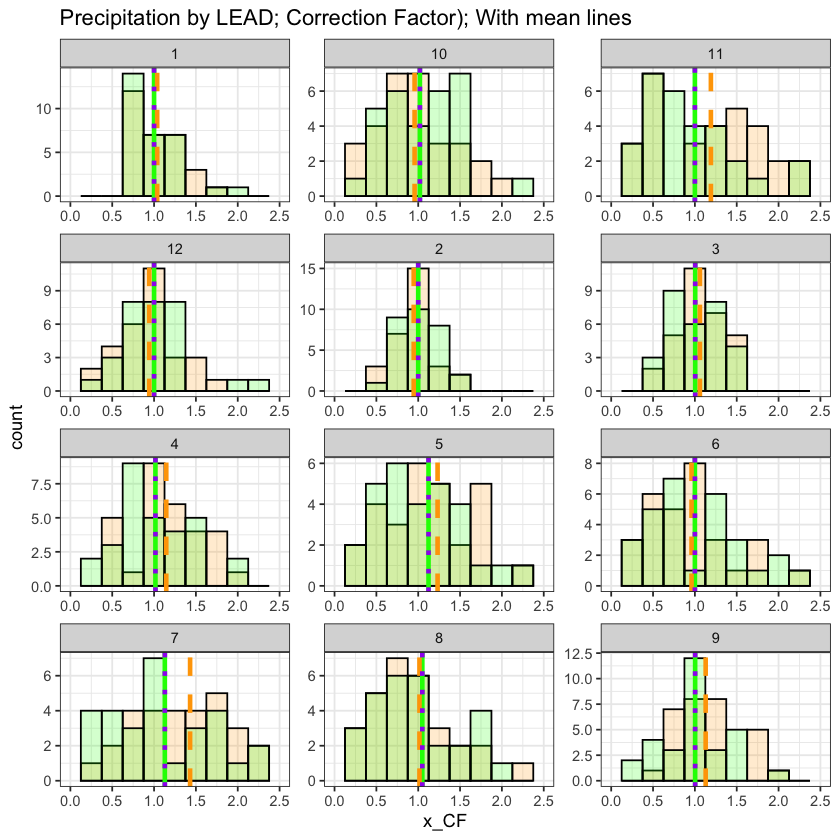

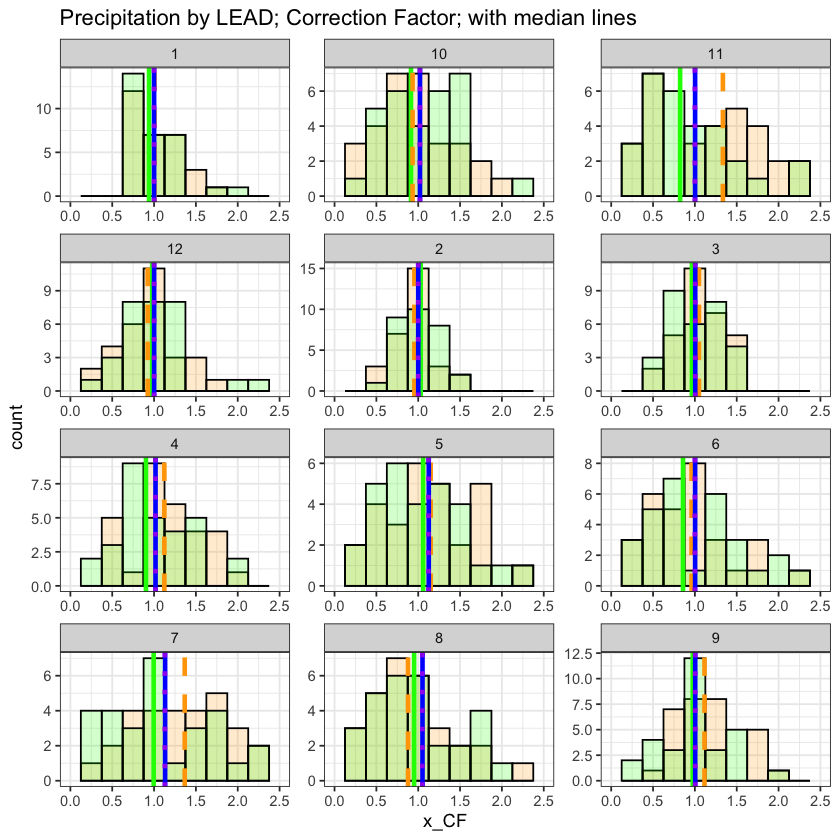

In [19]:
# ---------------------- CF -----------------------------
# CF values calculated as forecasted val / CLIMATOLOGICAL MEDIAN
# 1 (Orange)
pptNWSDensityMean <- pptNWSDensity[,.(UVNWSmean = mean(UVNWS_PPT_CF)), .(LEAD)]
pptNWSDensityMedian <- pptNWSDensity[,.(UVNWSmedian = median(UVNWS_PPT_CF)), .(LEAD)]

# 2 (Green)
pptGenAnoms <- data.table(generatedAnomData [, , "PPT_CF"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]
pptGenAnomsMedian <- pptGenAnoms[,.(MVGenMed = median(value)),.(LEAD)]

# 3 Analytical (BLUE)
pptAnalyticalDensityMean <- setDT(pptAnalyticalDensity)[,.(AnalyticalMean_CF = mean(x_CF)),.(LEAD)]
pptAnalyticalDensityMedian <- setDT(pptAnalyticalDensity)[,.(AnalyticalMedian_CF = median(x_CF)),.(LEAD)]

# Make Table of means
AllPPTMeans_CF <- cbind(pptNWSDensityMean, MVGenMean = pptGenAnomsMean$MVGenMean, 
                       AnalyticalMean =  pptAnalyticalDensityMean$AnalyticalMean_CF, NWS_PPT_CF = PPTAnoms$Anom_CF)
AllPPTMedians_CF <- cbind(pptNWSDensityMedian, MVGenMed = pptGenAnomsMedian$MVGenMed, 
                          AnalyticalMedian = pptAnalyticalDensityMedian$AnalyticalMedian_CF, NWS_PPT_CF = PPTAnoms$Anom_CF)

# plot

# scale!
bw3 <- .25 # binwidth .. important for scaling y axis to a count
#pptAnalyticalDensity$y_CF_scale <- pptAnalyticalDensity$y_CF * bw3 * nobs

p3 <- ggplot(pptAnalyticalDensity, aes(x = x_CF)) + 
  geom_histogram(data = pptNWSDensity, aes(x = UVNWS_PPT_CF), color = 'black', fill = 'orange', alpha = .2, binwidth = bw3) +
  geom_histogram(data = pptGenAnoms, aes(x = value),  color = 'black', fill = 'green', alpha = .2,  binwidth = bw3) +
  
  facet_wrap(~ LEAD, scales = 'free', nrow =4) +
  theme_bw() 

p3Means <- p3 +  
  
  labs(title = 'Precipitation by LEAD; Correction Factor); With mean lines') +
  
  #means
  geom_vline(data = pptGenAnomsMean, aes(xintercept = MVGenMean), color = 'green', size = 1.3)+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = UVNWSmean), color = 'orange', size = 1.3, lty = 'dashed') +
 # geom_vline(data = pptAnalyticalDensityMean, aes(xintercept = AnalyticalMean_CF), color = 'blue', size = 1.5) +
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = Anom_CF), color = 'purple', size = 1.3,  lty = 'dotted')


p3Medians <- p3 +
  
  labs(title = 'Precipitation by LEAD; Correction Factor; with median lines') +
  
  geom_vline(data = pptGenAnomsMedian, aes(xintercept = MVGenMed), color = 'green', size = 1.3) +
  geom_vline(data = pptNWSDensityMedian, aes(xintercept = UVNWSmedian), color = 'orange', size = 1.3, lty = 'dashed')+
  geom_vline(data = pptAnalyticalDensityMedian, aes(xintercept = AnalyticalMedian_CF), color = 'blue', size = 1.3) +
  
  geom_vline(data = PPTAnoms[1:12,], aes(xintercept = Anom_CF), color = 'purple', size = 1.3, lty = 'dotted') 


p3MediansZoom <- p3Medians +    xlim(0, 2.5)
# ---------------------------------
print('Table of Means - Correction Factor')
AllPPTMeans_CF
#p3Means
p3Means +    xlim(0, 2.5)

print('Table of Medians - Correction Factor')
AllPPTMedians_CF
#p3Medians
p3MediansZoom


Next, the anomalies generated for each lead must be transformed into monthly values so we can apply the anomalies to the historical data. Using the monthLeads table we loop through each month and find the affiliated leads. Values are then averaged across leads for monthly temperature anomaly and precipiation correction factor.

Finally, these monthly anomalies are then added (temp) or multipled (ppt) to each day in the relative month across the historical series, to generate future daily data for a 30 year period.


In [25]:
# Step 3 Get monthly averages across leads --------------------------------------------------
nn <- 1
OneYearAnom <- generatedAnomData[ , nn, ]
    
yearlydat <- data.frame(matrix(nrow = 12, ncol = 3))
names(yearlydat) <- c('tempAnom', 'pptAnom_cm', 'pptAnom_CF')
yearlydat$Month <- as.numeric(row.names(yearlydat))
  
for(m in c(yearlydat$Month)){ # for each month, m, in a year, nn
    
    mLeads <- c(t(monthLeads[monthLeads$Month == m, 3:5]))

    #temp
    yearlydat[m, 1] <- mean(OneYearAnom[mLeads, 'dT_C'], na.rm = TRUE) 
      
    # ppt cm # don't use this for calculations but downstream for looking at differences in predicted data
    OneYearAnom  <- cbind(OneYearAnom, Anom_cm =  OneYearAnom[,4] - PPTAnoms$ClimatatologicalMEAN_PPT_cm[1:12])
    yearlydat[m, 2] <-  mean(OneYearAnom[mLeads, 'Anom_cm'], na.rm = TRUE)
      
    # ppt correction factor
    yearlydat[m, 3] <-  mean(OneYearAnom[mLeads, 'PPT_CF'], na.rm = TRUE)

}
print(yearlydat)

print('summary of weather data before anomalies')
summary(wdata)
### Find month in wdata and merge anomalies
wdata$Month <-  month(as.Date(strptime(paste(wdata$Year, wdata$DOY), format="%Y %j"), format="%m-%d-%Y"))
wdata <- merge(wdata, yearlydat)

### Temp ------------------------------------------------------------------------------------ 
wdata$Tmax_C <- wdata$Tmax_C + wdata$tempAnom
wdata$Tmin_C <- wdata$Tmin_C + wdata$tempAnom

### Precip ----------------------------------------------------------------------------
wdata$PPT_cm <- wdata$PPT_cm * wdata$pptAnom_CF

# That's it
wdata <- wdata[,c('Year', 'DOY', 'Tmax_C', 'Tmin_C', 'PPT_cm')]
print('summary of weather data after anomalies')
summary(wdata)

     tempAnom pptAnom_cm pptAnom_CF Month
1  0.65425874 -0.2027707  1.5436609     1
2  0.41508386  3.7275290  2.2783487     2
3  0.68991323  2.7303108  1.9075670     3
4  0.09577628  2.8734856  1.6657816     4
5  0.42770568 -1.1990286  0.6678916     5
6  0.30521279 -1.1920307  0.6485987     6
7  0.42195830 -0.3383323  0.7791095     7
8  0.54349294 -2.6115859  0.5396206     8
9  0.17573081  0.4280373  0.5435231     9
10 0.16622224  0.6221010  0.6576947    10
11 0.31159922  1.5321211  0.9295702    11
12 0.57227777 -0.2910585  1.3223974    12
[1] "summary of weather data before anomalies"


     Date                Year           DOY            Tmax_C      
 Length:15341       Min.   :1979   Min.   :  1.0   Min.   :-8.912  
 Class :character   1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.202  
 Mode  :character   Median :2000   Median :183.0   Median :17.783  
                    Mean   :2000   Mean   :183.1   Mean   :17.403  
                    3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.264  
                    Max.   :2020   Max.   :366.0   Max.   :44.891  
     Tmin_C             PPT_cm       
 Min.   :-25.3087   Min.   :0.00000  
 1st Qu.: -4.5787   1st Qu.:0.00000  
 Median :  0.7622   Median :0.00000  
 Mean   :  1.3686   Mean   :0.15378  
 3rd Qu.:  7.9749   3rd Qu.:0.06728  
 Max.   : 32.2334   Max.   :9.29819  

[1] "summary of weather data after anomalies"


      Year           DOY            Tmax_C           Tmin_C       
 Min.   :1979   Min.   :  1.0   Min.   :-8.497   Min.   :-24.736  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.678   1st Qu.: -4.124  
 Median :2000   Median :183.0   Median :18.091   Median :  1.086  
 Mean   :2000   Mean   :183.1   Mean   :17.803   Mean   :  1.769  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.607   3rd Qu.:  8.280  
 Max.   :2020   Max.   :366.0   Max.   :45.196   Max.   : 32.539  
     PPT_cm        
 Min.   : 0.00000  
 1st Qu.: 0.00000  
 Median : 0.00000  
 Mean   : 0.18292  
 3rd Qu.: 0.06054  
 Max.   :14.35325  

### Monthly - generated monthly anom data vs. NWS data (NWS lead data averaged to correct month)

[1] "Density and box plots of monthly anomalies used in SOILWAT2 vs NWS"


Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


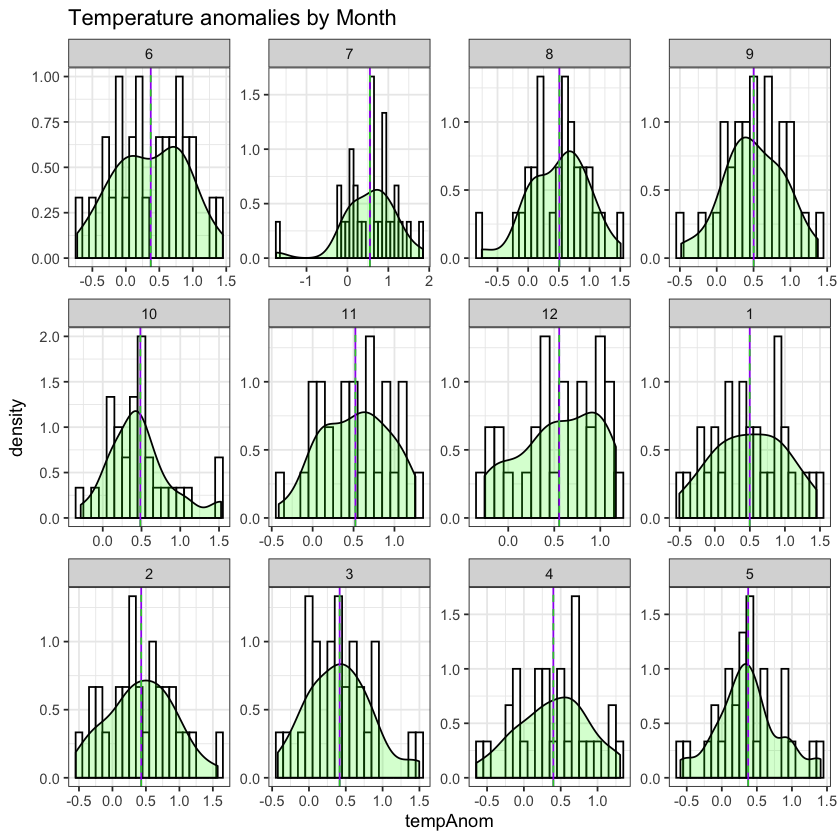

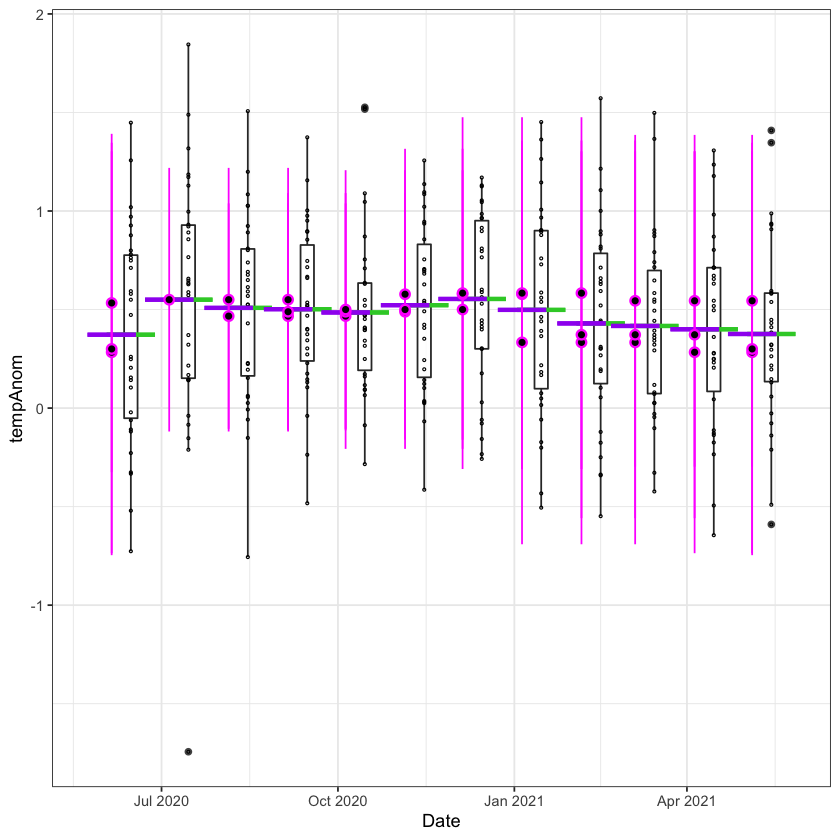

In [21]:
source('figureCode/FigureDataPrep.R')
# Plots comparing the distribution of generated anomaly data at the Monthly level
# to NWS values for the same monthly periods

print('Density and box plots of monthly anomalies used in SOILWAT2 vs NWS')
MonthlyAnoms2 <- MonthlyAnoms # monthly anamoly data entered into SW
MonthlyAnoms2$Month <- factor(MonthlyAnoms2$Month, levels = c(6:12, 1:5))
generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(tempAnom)), .(Month)]

# ----- 100 sets of monthly anomalies vs. affiliated NWS data
# temperature
NWSMeans <- setDT(NWSAnomsAll1)[,.(meanAnom = mean(Anom_C)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

ggplot(MonthlyAnoms2, aes(tempAnom)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white", binwidth =.1)+
  geom_density(alpha=.2, fill="green") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Temperature anomalies by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanAnom), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

ggplot() + 
  geom_boxplot(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanAnom, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll1, aes(Date, Anom_C,
                                           ymin = Anom_C - ForecastedSD_Temp_C,
                                           ymax = Anom_C + ForecastedSD_Temp_C), shape = 21, fill = 'black', color = 'magenta') +
   theme_bw()
  




Month meanForecastDiff Year Date      
1  1     0.283333333      2021 2021-01-05
2  2     0.206666667      2021 2021-02-05
3  3     0.210000000      2021 2021-03-05
4  4     0.080000000      2021 2021-04-05
5  5     0.020000000      2021 2021-05-05
6  6     0.016666667      2020 2020-06-05
7  7     0.000000000      2020 2020-07-05
8  8     0.000000000      2020 2020-08-05
9  9     0.006666667      2020 2020-09-05
10 10    0.026666667      2020 2020-10-05
11 11    0.163333333      2020 2020-11-05
12 12    0.156666667      2020 2020-12-05

Month meanGenAnom 
1  1     2.398889e-01
2  2     1.749778e-01
3  3     1.778000e-01
4  4     6.773333e-02
5  5     1.693333e-02
6  6     1.411111e-02
7  7     3.626729e-16
8  8     7.586524e-17
9  9     5.644444e-03
10 10    2.257778e-02
11 11    1.382889e-01
12 12    1.326444e-01

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 13 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 13 rows containing non-finite values (stat_density).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“R

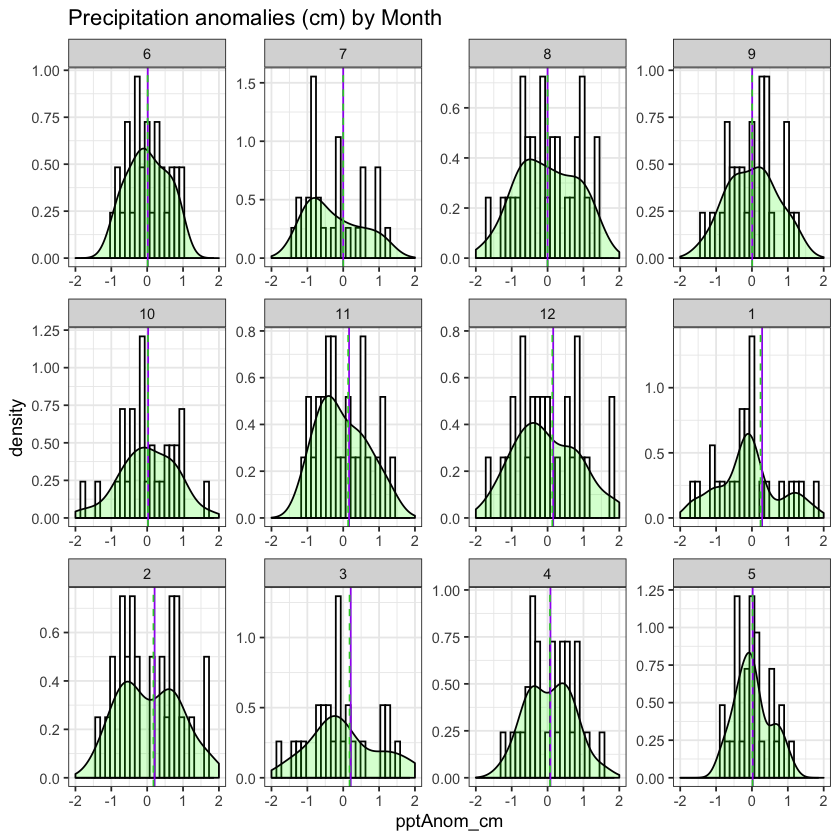

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 24 rows containing missing values (geom_bar).”


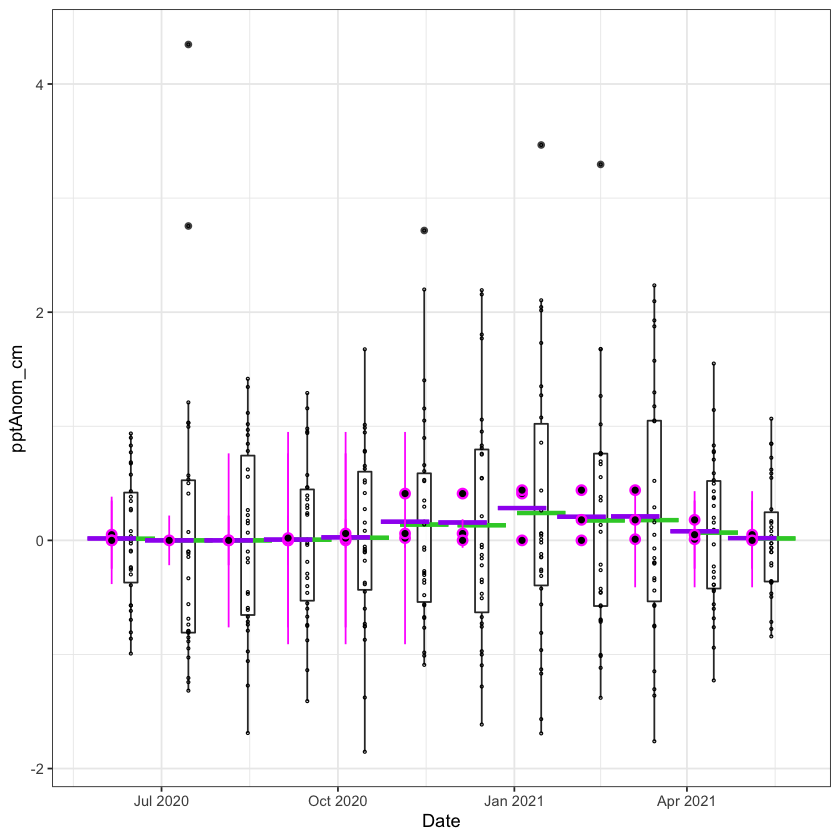

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


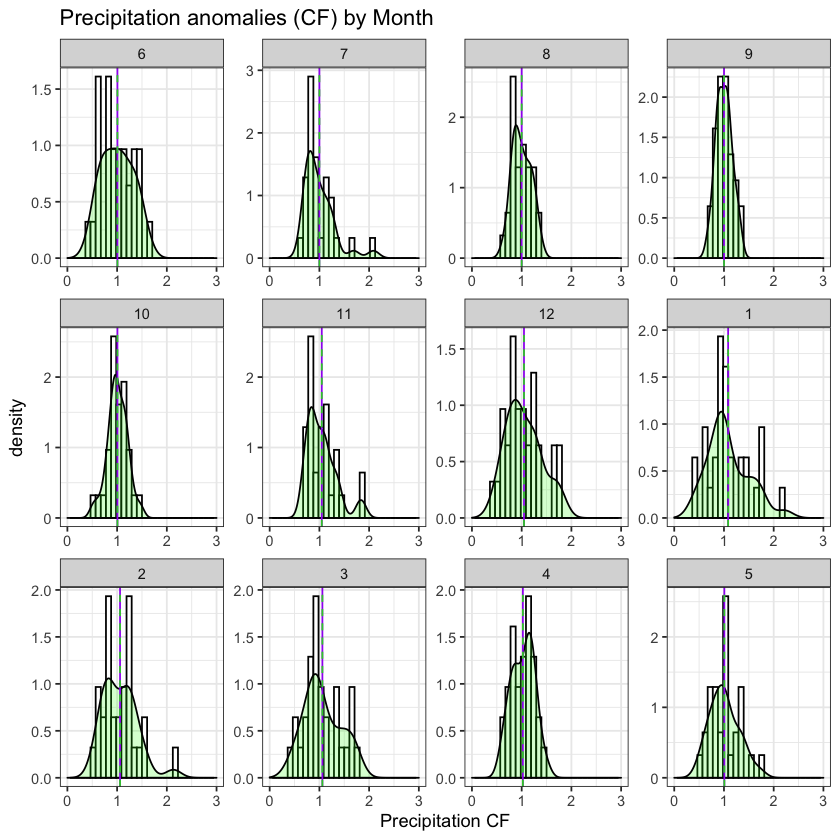

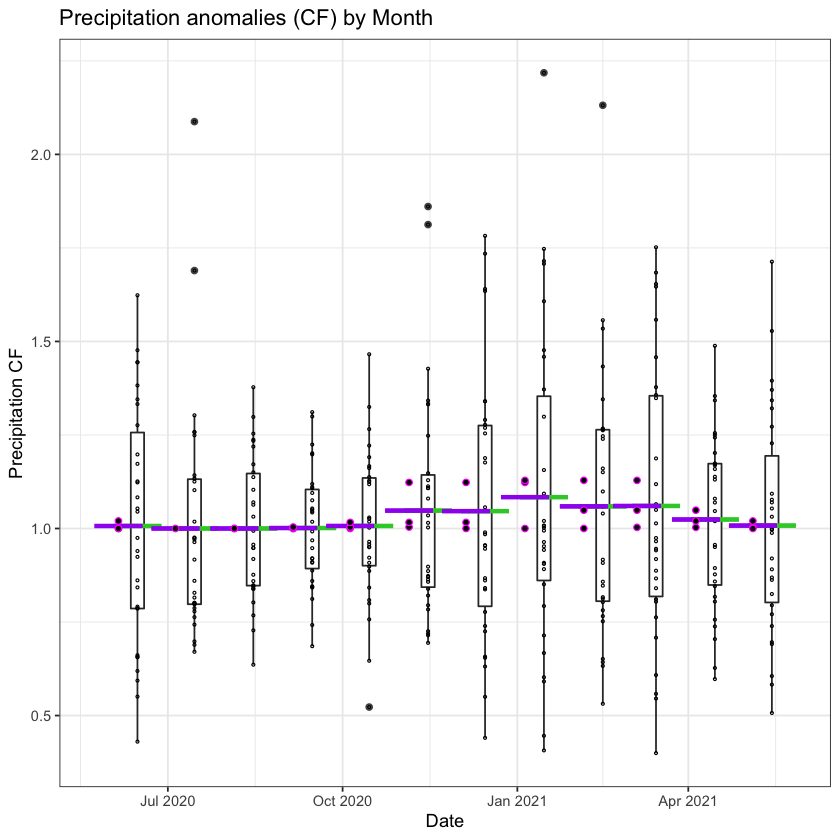

In [22]:
# Plots comparing the distribution of generated anomaly data at the Monthly level
# to NWS values for the same monthly periods
# precip

# cm
NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(Anom_cm)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))
NWSMeans

generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(pptAnom_cm)), .(Month)]
generatedMean

# hists
ggplot(MonthlyAnoms2, aes(pptAnom_cm)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="green") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Precipitation anomalies (cm) by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw() +
  xlim(-2, 2)

# boxplots
ggplot() +
  geom_boxplot(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll2, aes(Date, Anom_cm,
                                           ymin = Anom_cm - ForecastedSD_PPT_cm,
                                           ymax = Anom_cm + ForecastedSD_PPT_cm), shape = 21, fill = 'black', color = 'magenta') +
  theme_bw()


# CF
NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(Anom_CF)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(pptAnom_CF)), .(Month)]

# hists
ggplot(MonthlyAnoms2, aes(pptAnom_CF)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="green") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Precipitation anomalies (CF) by Month', x = 'Precipitation CF') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw() +
  xlim(0, 3)

# boxplots
ggplot() +
  geom_boxplot(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_point(data = NWSAnomsAll2, aes(Date, Anom_CF), shape = 21, fill = 'black', color = 'magenta') +
  labs(title = 'Precipitation anomalies (CF) by Month', y = 'Precipitation CF') +
  
  
  theme_bw()






Next, three-year long SOILWAT2 simulations are run using this data. First year is observed data for spin up , second year is part observed and the future, third year is the rest of the future and then dummy data after today's date + 12 months. The anomalies are applied to each year in the historical record for each future (i.e. 30 years). EAch year is run individually so therre is proper spin up and not confound the accumulation of certain conditions and represent the range of possible conditions at the site. This entire process is repeated 30 times, resulting in 900 years.

# Downscaling Results




In [35]:
### Tempererature time series - 18 month period - absolutes and differrences

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 346 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”


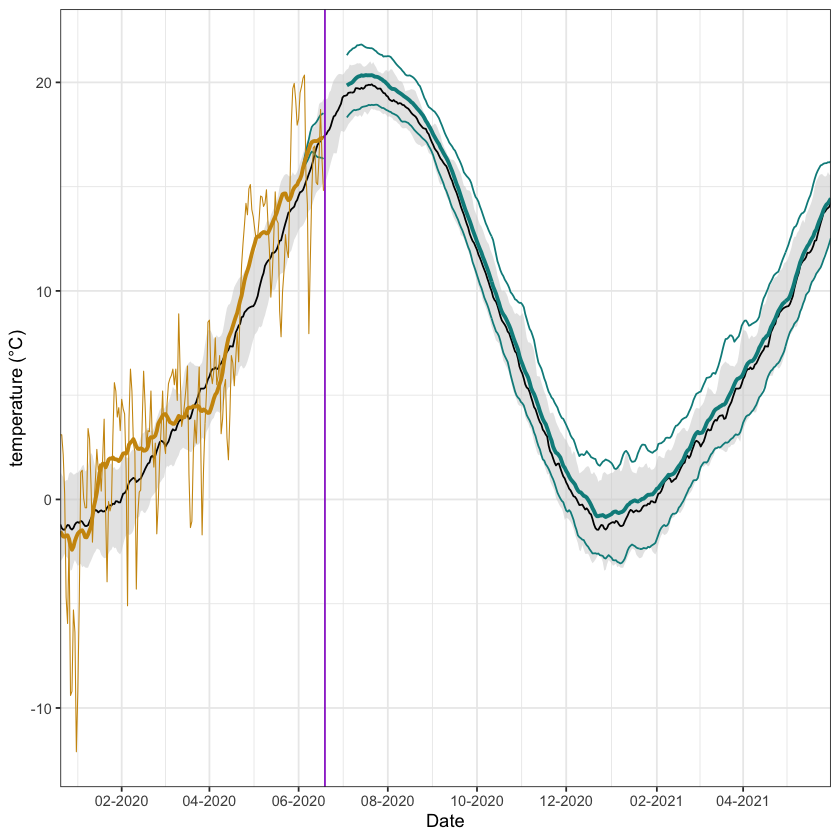

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messa

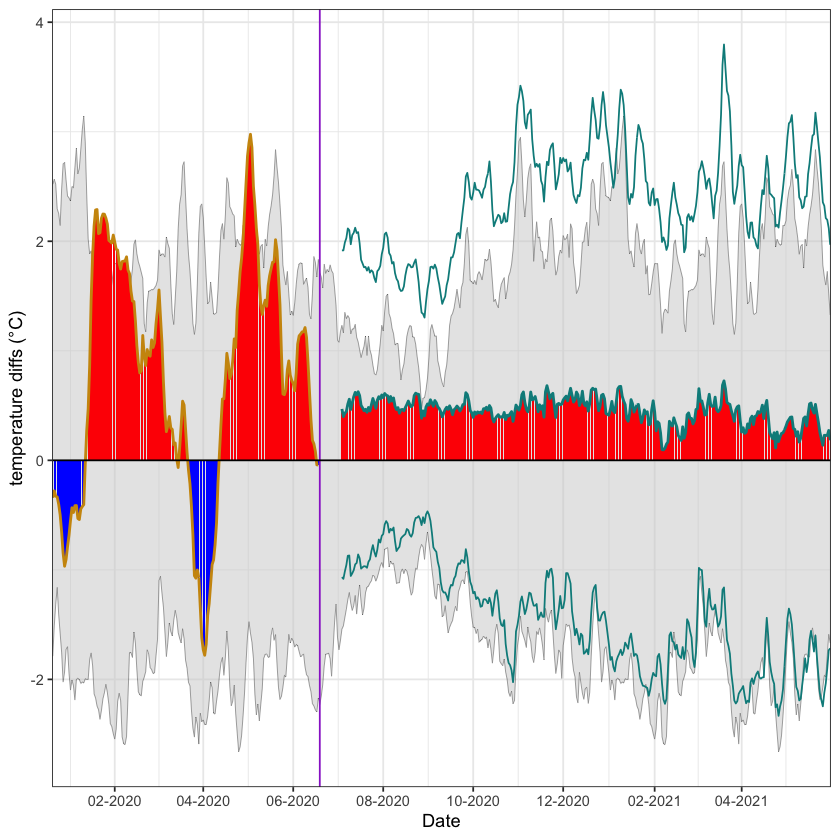

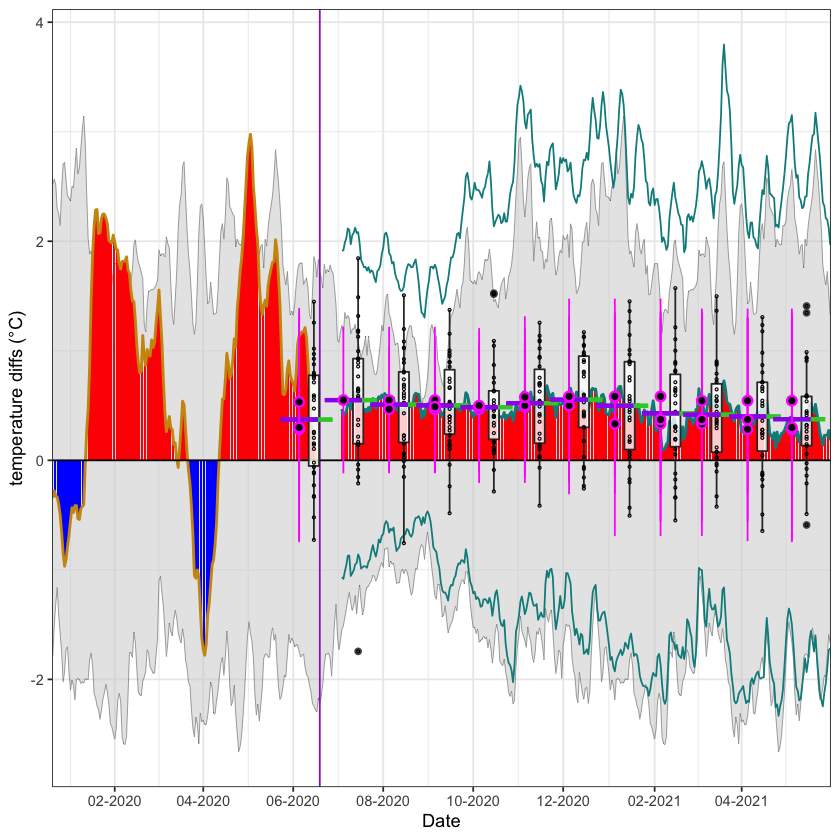

In [24]:
####### This is a lot of code!
source('figureCode/presentationFigs/Temperature.R')


Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 346 rows containing missing values (position_stack).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”


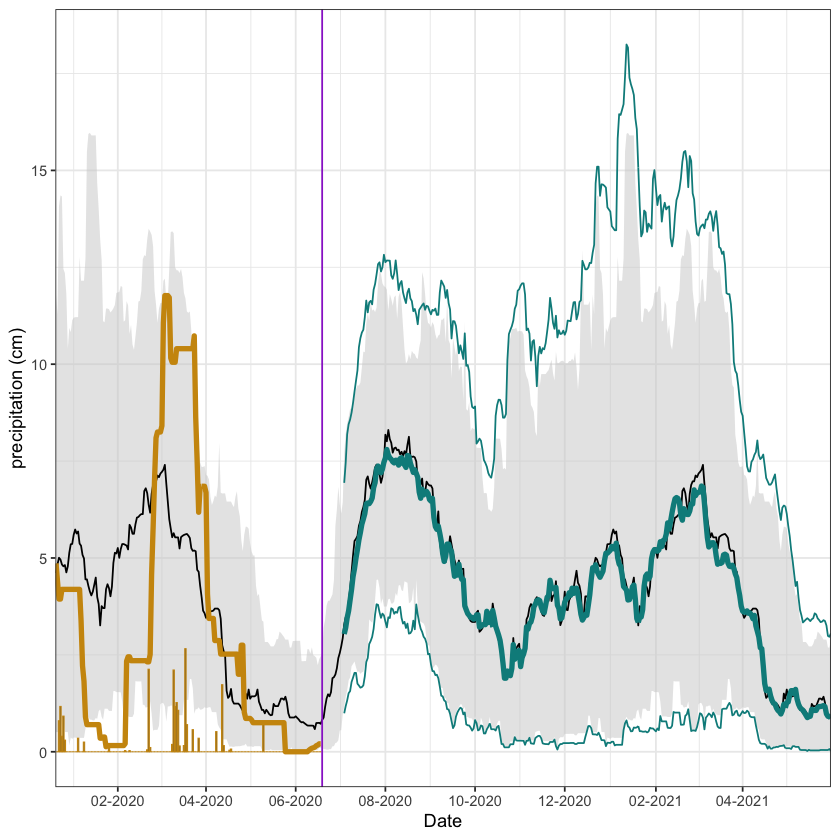

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messa

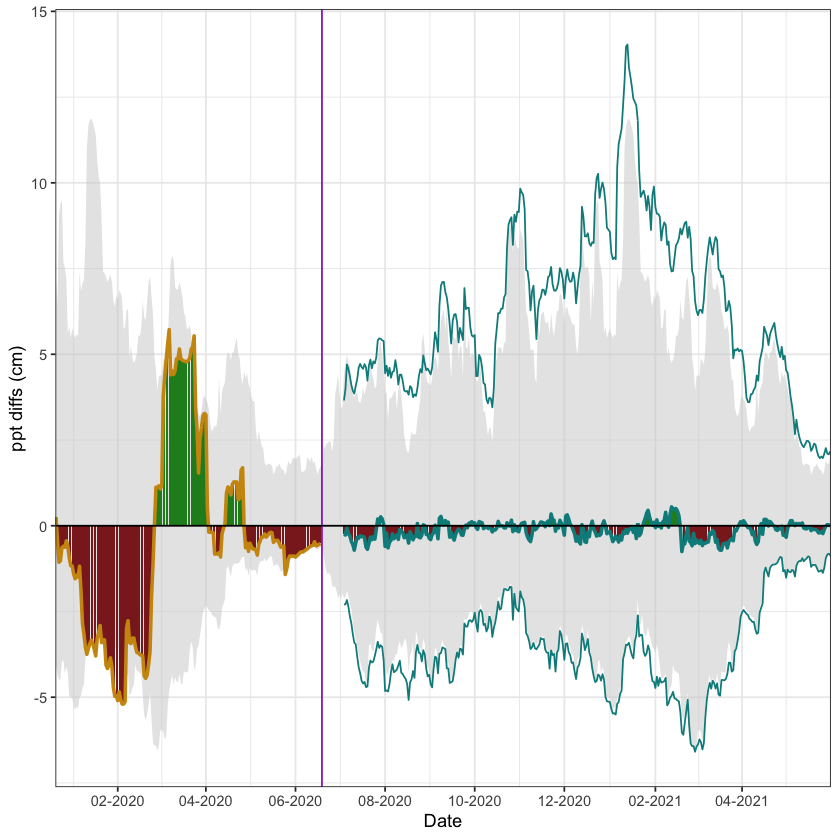

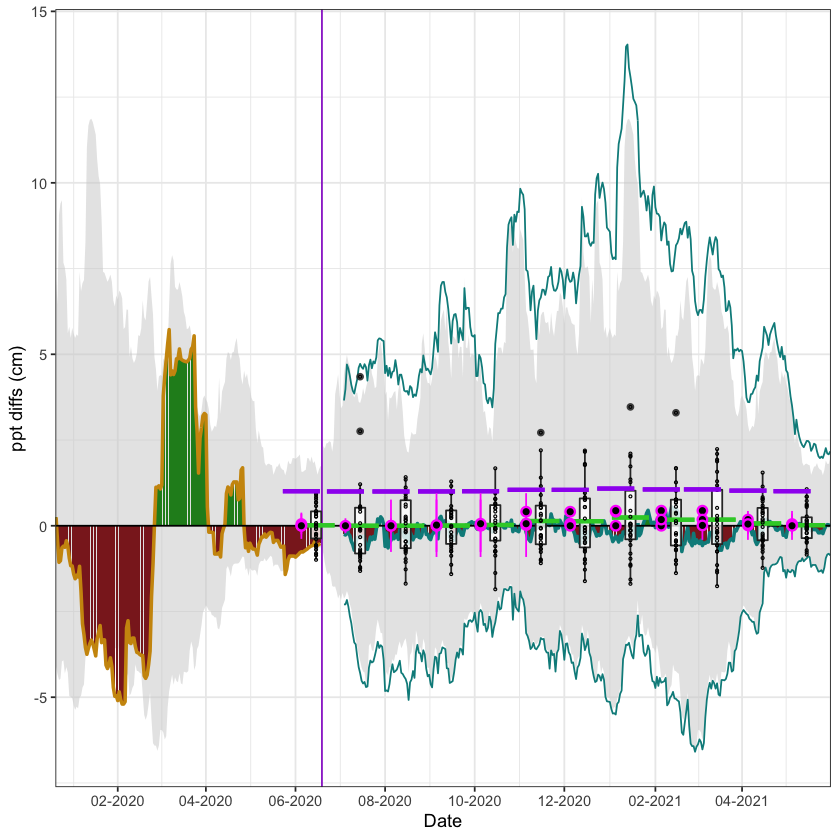

In [25]:
source('figureCode/presentationFigs/precipitation.R')